# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegressionMixed
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 23:06:13.497627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:06:13.538143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:06:13.538645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:06:14.123578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 3 # input dimensions
    
seed = 1
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 100
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegressionMixed(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [422.85178466 723.12124851  10.11323107]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 1141027840.0000 - mae: 213197.2344 - mse: 112804052992.0000 - val_loss: 632695040.0000 - val_mae: 169462.7188 - val_mse: 62544375808.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 628817856.0000 - mae: 164809.4219 - mse: 62161379328.0000 - val_loss: 562376128.0000 - val_mae: 159204.1406 - val_mse: 55592235008.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 590329152.0000 - mae: 160516.0000 - mse: 58356088832.0000 - val_loss: 552149632.0000 - val_mae: 160091.3438 - val_mse: 54580936704.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 591723840.0000 - mae: 161462.9375 - mse: 58493939712.0000 - val_loss: 571453696.0000 - val_mae: 152530.7031 - val_mse: 56490471424.0000
Epoch 5/6
517/517 [==============================] - 1s 3ms/step - loss: 572300672.0000 - mae: 158092.4844 - mse: 565

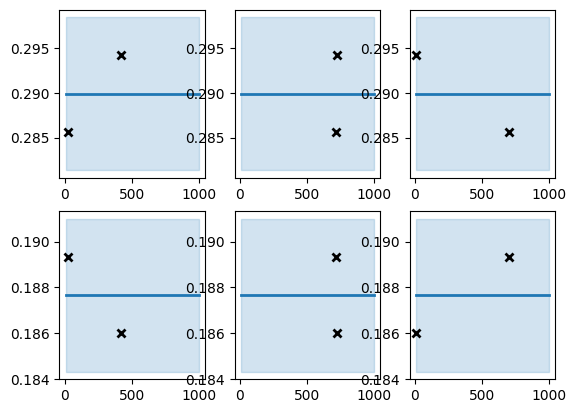

x_best =  [222.47387838  23.28842011 707.4700317 ]
acq_best =  [0.00170439 0.00066581]
C = [222.47387838  23.28842011 707.4700317 ]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 106048339968.0000 - mae: 249343.5000 - mse: 149897641984.0000 - val_loss: 83519406080.0000 - val_mae: 218084.1719 - val_mse: 118053322752.0000
Epoch 2/6
517/517 [==============================] - 0s 930us/step - loss: 72174436352.0000 - mae: 200418.1875 - mse: 102017253376.0000 - val_loss: 58160578560.0000 - val_mae: 194238.0469 - val_mse: 82208972800.0000
Epoch 3/6
517/517 [==============================] - 0s 917us/step - loss: 49421574144.0000 - mae: 167692.9375 - mse: 69856624640.0000 - val_loss: 42976751616.0000 - val_mae: 162823.3125 - val_mse: 60746854400.0000
Epoch 4/6
517/517 [==============================] - 0s 922us/step - loss: 44883460096.0000 - mae: 165048.0156 - mse: 63441977344.0000 - val_loss: 41880887296.0000 - val_mae: 158140.6719 - val_mse: 59197898752.0000
Epoch 

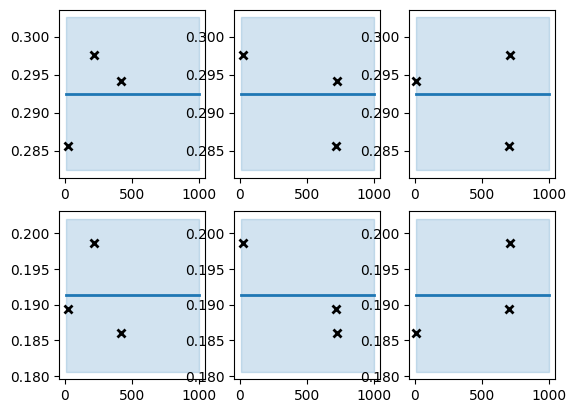

x_best =  [925.14169008 899.56768625 203.79857712]
acq_best =  [0.0020045  0.00212789]
C = [925.14169008 899.56768625 203.79857712]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 86215614464.0000 - mae: 538371.7500 - mse: 423040843776.0000 - val_loss: 87642701824.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 86215614464.0000 - mae: 538371.6250 - mse: 423040843776.0000 - val_loss: 87642701824.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 86215614464.0000 - mae: 538371.2500 - mse: 423040909312.0000 - val_loss: 87642701824.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 86215639040.0000 - mae: 538371.5000 - mse: 423040876544.0000 - val_loss: 87642701824.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

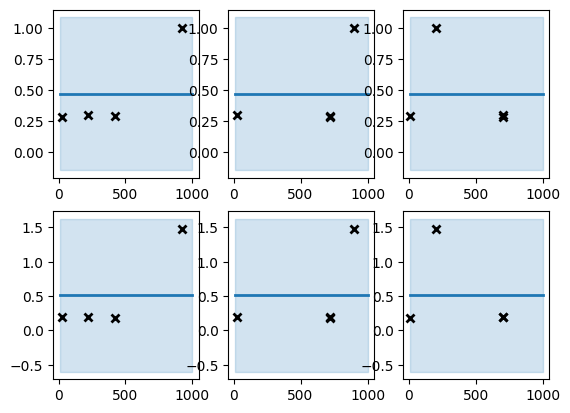

x_best =  [408.91713911 812.48599924 186.21243656]
acq_best =  [0.12305985 0.2216403 ]
C = [408.91713911 812.48599924 186.21243656]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 21408088064.0000 - mae: 214641.3750 - mse: 114964750336.0000 - val_loss: 12375169024.0000 - val_mae: 165789.0781 - val_mse: 66456391680.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 11696708608.0000 - mae: 164513.4375 - mse: 62812884992.0000 - val_loss: 10097308672.0000 - val_mae: 153541.4375 - val_mse: 54223851520.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 10980295680.0000 - mae: 161499.1562 - mse: 58965663744.0000 - val_loss: 10368300032.0000 - val_mae: 153909.2188 - val_mse: 55679139840.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 10638256128.0000 - mae: 158702.7188 - mse: 57128779776.0000 - val_loss: 9819101184.0000 - val_mae: 151078.2969 - val_mse: 52729823232.0000
Epoch 5/6
517/51

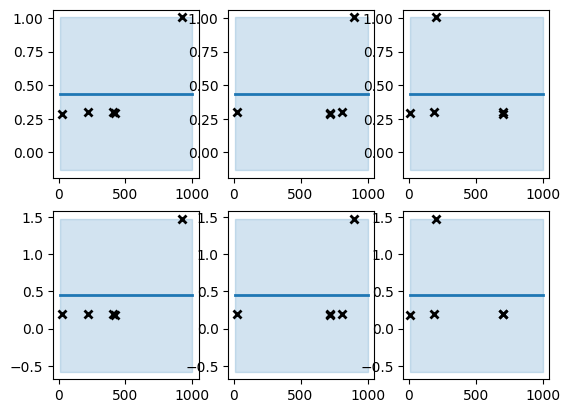

x_best =  [841.02192549 707.57911195 985.8914488 ]
acq_best =  [0.11328336 0.20483085]
C = [841.02192549 707.57911195 985.8914488 ]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 105011904512.0000 - mae: 205336.0312 - mse: 106514407424.0000 - val_loss: 68320735232.0000 - val_mae: 188801.0156 - val_mse: 69298241536.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 61017907200.0000 - mae: 165470.5625 - mse: 61890940928.0000 - val_loss: 61792931840.0000 - val_mae: 179683.2656 - val_mse: 62677032960.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 58416496640.0000 - mae: 161574.0156 - mse: 59252314112.0000 - val_loss: 57375191040.0000 - val_mae: 159146.2188 - val_mse: 58196107264.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 57604861952.0000 - mae: 160544.5625 - mse: 58429054976.0000 - val_loss: 52523622400.0000 - val_mae: 152577.6719 - val_mse: 53275095040.0000
Epoch 5/6
517/

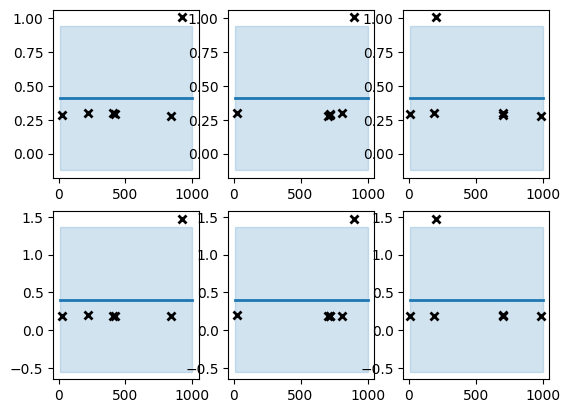

x_best =  [300.43282641 309.18602966 201.09552134]
acq_best =  [0.10606423 0.1908868 ]
C = [300.43282641 309.18602966 201.09552134]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 25959153664.0000 - mae: 227146.3281 - mse: 129087635456.0000 - val_loss: 18483918848.0000 - val_mae: 187154.9688 - val_mse: 91915223040.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 14020067328.0000 - mae: 169198.8594 - mse: 69717622784.0000 - val_loss: 12276269056.0000 - val_mae: 158746.0625 - val_mse: 61046169600.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 12151442432.0000 - mae: 162433.8438 - mse: 60425367552.0000 - val_loss: 11582531584.0000 - val_mae: 158498.8125 - val_mse: 57596391424.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 11751743488.0000 - mae: 160473.7656 - mse: 58437812224.0000 - val_loss: 10973367296.0000 - val_mae: 156027.0312 - val_mse: 54567170048.0000
Epoch 5/6
517/5

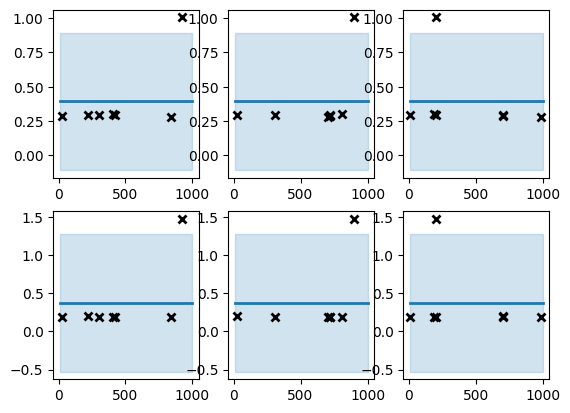

x_best =  [846.27634371 543.2726015  435.50578448]
acq_best =  [0.0995953  0.17933132]
C = [846.27634371 543.2726015  435.50578448]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 45360308224.0000 - mae: 205002.5469 - mse: 104154980352.0000 - val_loss: 26171631616.0000 - val_mae: 169619.8438 - val_mse: 60094418944.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 26745593856.0000 - mae: 165441.4062 - mse: 61412343808.0000 - val_loss: 25450760192.0000 - val_mae: 164087.0312 - val_mse: 58439159808.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 25894989824.0000 - mae: 162183.5781 - mse: 59459170304.0000 - val_loss: 23868381184.0000 - val_mae: 155934.0000 - val_mse: 54805766144.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 25373349888.0000 - mae: 160346.0781 - mse: 58261409792.0000 - val_loss: 23415408640.0000 - val_mae: 154837.6094 - val_mse: 53765664768.0000
Epoch 5/6
517/5

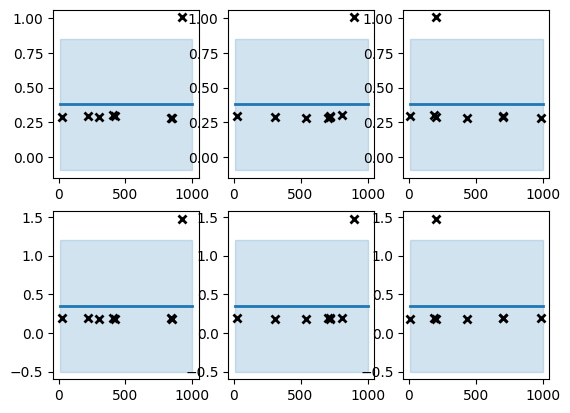

x_best =  [420.16674981 389.5578493   66.85451801]
acq_best =  [0.09434891 0.16961721]
C = [420.16674981 389.5578493   66.85451801]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 7671729664.0000 - mae: 215768.1094 - mse: 114749341696.0000 - val_loss: 4258339840.0000 - val_mae: 163220.7812 - val_mse: 63693172736.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 4211929088.0000 - mae: 164210.9531 - mse: 62998929408.0000 - val_loss: 4040426752.0000 - val_mae: 160016.0938 - val_mse: 60433715200.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 3917286656.0000 - mae: 160467.3750 - mse: 58591789056.0000 - val_loss: 3839016448.0000 - val_mae: 159100.5938 - val_mse: 57421058048.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 3874321664.0000 - mae: 160295.0938 - mse: 57949110272.0000 - val_loss: 3880145920.0000 - val_mae: 170898.2500 - val_mse: 58036097024.0000
Epoch 5/6
517/517 [====

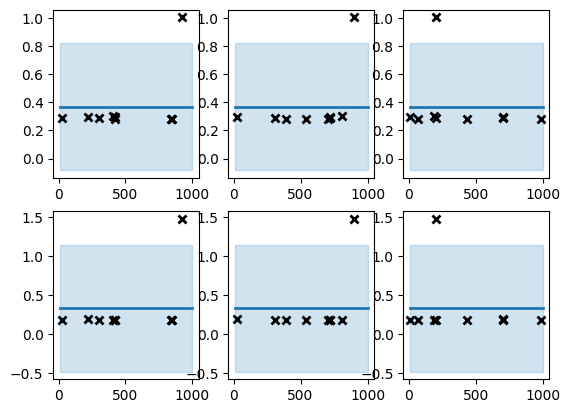

x_best =  [795.18529071  27.40034826 833.54559377]
acq_best =  [0.08976035 0.16117092]
C = [795.18529071  27.40034826 833.54559377]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 110053597184.0000 - mae: 230549.6094 - mse: 132030390272.0000 - val_loss: 74794344448.0000 - val_mae: 188122.3438 - val_mse: 89730146304.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 58053345280.0000 - mae: 168716.4844 - mse: 69646024704.0000 - val_loss: 48251342848.0000 - val_mae: 164024.4062 - val_mse: 57886679040.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 50745593856.0000 - mae: 163401.9688 - mse: 60879044608.0000 - val_loss: 46803607552.0000 - val_mae: 157053.9219 - val_mse: 56149827584.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 49858379776.0000 - mae: 161905.4062 - mse: 59814649856.0000 - val_loss: 46588481536.0000 - val_mae: 159210.9844 - val_mse: 55891767296.0000
Epoch 5/6
517/

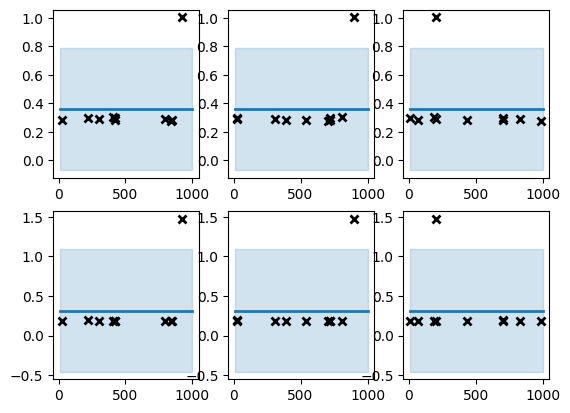

x_best =  [205.95844538 323.75136871 837.83927382]
acq_best =  [0.085673   0.15392041]
C = [205.95844538 323.75136871 837.83927382]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 112177045504.0000 - mae: 234208.0469 - mse: 133888286720.0000 - val_loss: 84787617792.0000 - val_mae: 200216.5469 - val_mse: 101197692928.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 61454405632.0000 - mae: 173597.9375 - mse: 73348448256.0000 - val_loss: 50681065472.0000 - val_mae: 168236.8281 - val_mse: 60489998336.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 50772389888.0000 - mae: 162389.1406 - mse: 60599050240.0000 - val_loss: 48108761088.0000 - val_mae: 159241.4688 - val_mse: 57419841536.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 49041592320.0000 - mae: 160946.4531 - mse: 58533244928.0000 - val_loss: 45158457344.0000 - val_mae: 156766.0469 - val_mse: 53898547200.0000
Epoch 5/6
517

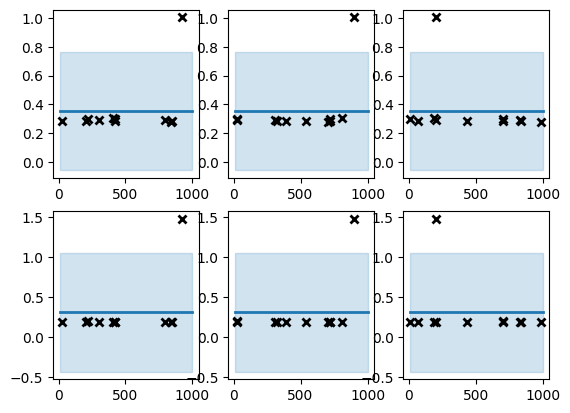

x_best =  [410.28323201 278.12484134  63.5308513 ]
acq_best =  [0.082126   0.14754325]
C = [410.28323201 278.12484134  63.5308513 ]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 26876663808.0000 - mae: 538371.5000 - mse: 423040811008.0000 - val_loss: 27321540608.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 26876667904.0000 - mae: 538371.6250 - mse: 423040909312.0000 - val_loss: 27321540608.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 26876682240.0000 - mae: 538371.5000 - mse: 423040614400.0000 - val_loss: 27321540608.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 26876686336.0000 - mae: 538371.5000 - mse: 423040811008.0000 - val_loss: 27321540608.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

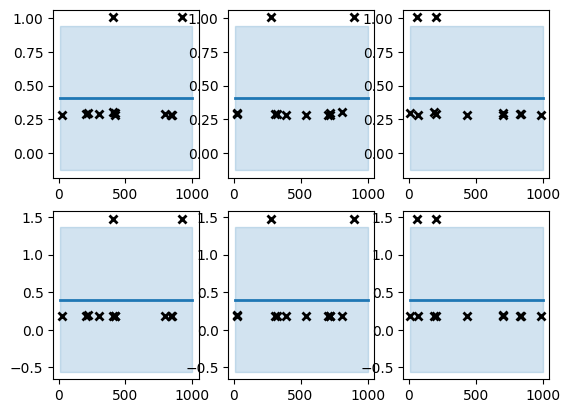

x_best =  [ 31.36052835 852.14239084 991.29228254]
acq_best =  [0.10643799 0.19126432]
C = [ 31.36052835 852.14239084 991.29228254]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 140290867200.0000 - mae: 240702.7500 - mse: 141522960384.0000 - val_loss: 116552114176.0000 - val_mae: 223220.3906 - val_mse: 117575671808.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 94946672640.0000 - mae: 195548.6562 - mse: 95780487168.0000 - val_loss: 76120170496.0000 - val_mae: 168843.1094 - val_mse: 76788654080.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 63409635328.0000 - mae: 163866.0938 - mse: 63966433280.0000 - val_loss: 55955329024.0000 - val_mae: 156290.2969 - val_mse: 56446713856.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 57704534016.0000 - mae: 159974.0156 - mse: 58211196928.0000 - val_loss: 54578688000.0000 - val_mae: 153453.8125 - val_mse: 55057956864.0000
Epoch 5/6
51

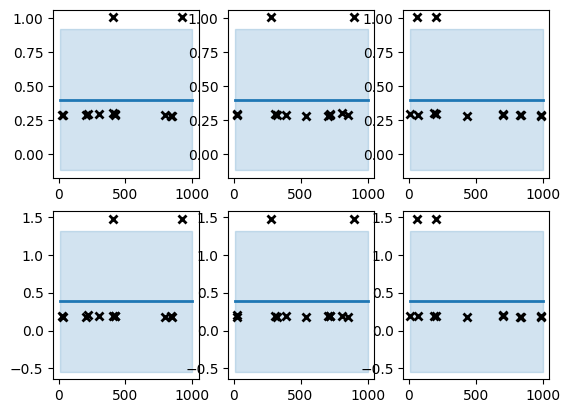

x_best =  [498.3310908  598.82115094 479.25020458]
acq_best =  [0.10307823 0.18522416]
C = [498.3310908  598.82115094 479.25020458]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 54484135936.0000 - mae: 210314.8594 - mse: 113685823488.0000 - val_loss: 31374233600.0000 - val_mae: 175496.0781 - val_mse: 65464885248.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 29388482560.0000 - mae: 163912.2500 - mse: 61321490432.0000 - val_loss: 26038530048.0000 - val_mae: 160540.5938 - val_mse: 54331486208.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 27484325888.0000 - mae: 158860.2188 - mse: 57348227072.0000 - val_loss: 29487880192.0000 - val_mae: 158673.6719 - val_mse: 61528875008.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 27540963328.0000 - mae: 158657.5625 - mse: 57466441728.0000 - val_loss: 26849622016.0000 - val_mae: 151702.3125 - val_mse: 56023920640.0000
Epoch 5/6
517/5

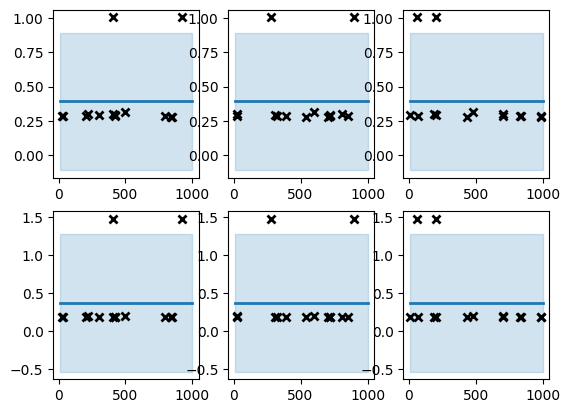

x_best =  [180.07021279 154.40344011 187.70056683]
acq_best =  [0.09970529 0.17954379]
C = [180.07021279 154.40344011 187.70056683]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 26161166336.0000 - mae: 238507.5938 - mse: 139375869952.0000 - val_loss: 21043083264.0000 - val_mae: 216363.6250 - val_mse: 112108724224.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 16069361664.0000 - mae: 186042.1719 - mse: 85610807296.0000 - val_loss: 11593566208.0000 - val_mae: 159523.2031 - val_mse: 61765439488.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 11651360768.0000 - mae: 164067.7500 - mse: 62073356288.0000 - val_loss: 10803082240.0000 - val_mae: 161990.5000 - val_mse: 57554022400.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 11160836096.0000 - mae: 161571.1250 - mse: 59460014080.0000 - val_loss: 10368545792.0000 - val_mae: 159156.5781 - val_mse: 55238967296.0000
Epoch 5/6
517/

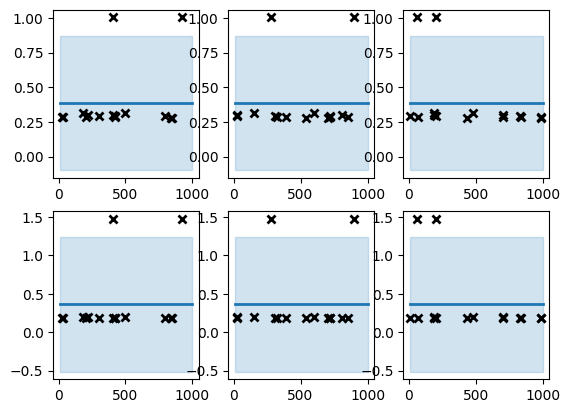

x_best =  [429.30972489 124.84876066 229.77628481]
acq_best =  [0.09664635 0.174257  ]
C = [429.30972489 124.84876066 229.77628481]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 97205248000.0000 - mae: 538371.5000 - mse: 423040712704.0000 - val_loss: 98814222336.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 97205231616.0000 - mae: 538371.4375 - mse: 423040581632.0000 - val_loss: 98814222336.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 97205248000.0000 - mae: 538371.6250 - mse: 423040516096.0000 - val_loss: 98814222336.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 97205280768.0000 - mae: 538371.4375 - mse: 423041073152.0000 - val_loss: 98814222336.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

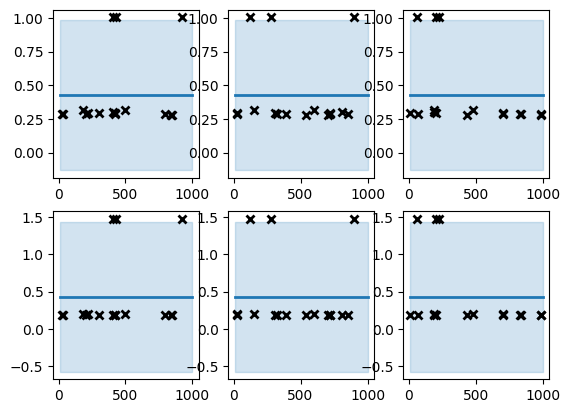

x_best =  [ 66.06129015 351.84718145  25.0576509 ]
acq_best =  [0.11093968 0.20007669]
C = [ 66.06129015 351.84718145  25.0576509 ]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 10600943616.0000 - mae: 538371.7500 - mse: 423041007616.0000 - val_loss: 10776410112.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 10600944640.0000 - mae: 538371.6250 - mse: 423040483328.0000 - val_loss: 10776410112.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 10600949760.0000 - mae: 538371.4375 - mse: 423040843776.0000 - val_loss: 10776410112.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 10600944640.0000 - mae: 538371.3125 - mse: 423040581632.0000 - val_loss: 10776410112.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

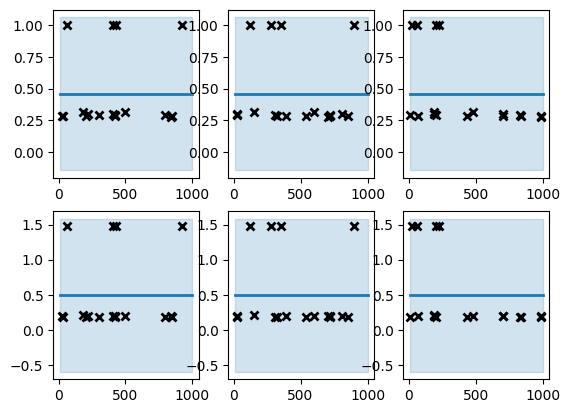

x_best =  [930.82040816 949.37059072 543.70537726]
acq_best =  [0.12055064 0.21743628]
C = [930.82040816 949.37059072 543.70537726]
Epoch 1/6
517/517 [==============================] - 10s 16ms/step - loss: 52354596864.0000 - mae: 198729.9219 - mse: 96291758080.0000 - val_loss: 40397967360.0000 - val_mae: 196527.0469 - val_mse: 74300825600.0000
Epoch 2/6
517/517 [==============================] - 7s 14ms/step - loss: 33352204288.0000 - mae: 165262.4219 - mse: 61342130176.0000 - val_loss: 29121474560.0000 - val_mae: 156321.7500 - val_mse: 53560848384.0000
Epoch 3/6
517/517 [==============================] - 7s 13ms/step - loss: 31521828864.0000 - mae: 160309.9375 - mse: 57975644160.0000 - val_loss: 30310424576.0000 - val_mae: 153640.0156 - val_mse: 55747600384.0000
Epoch 4/6
517/517 [==============================] - 8s 15ms/step - loss: 31649275904.0000 - mae: 160596.7344 - mse: 58210025472.0000 - val_loss: 28956884992.0000 - val_mae: 154543.7812 - val_mse: 53258129408.0000
Epoch 5/6
5

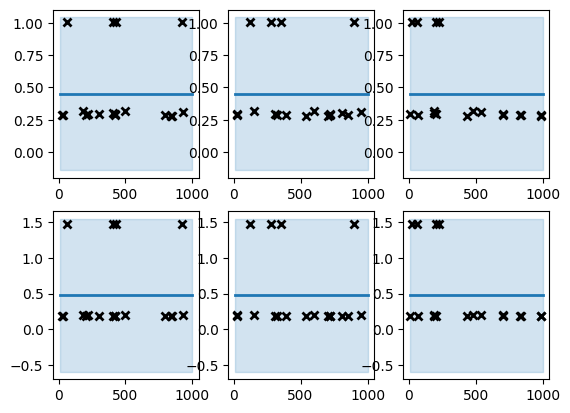

x_best =  [183.10037343 151.39833576 190.4941718 ]
acq_best =  [0.11798928 0.21305567]
C = [183.10037343 151.39833576 190.4941718 ]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 25451886592.0000 - mae: 232832.1250 - mse: 133608603648.0000 - val_loss: 20220618752.0000 - val_mae: 205156.5469 - val_mse: 106147176448.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 15092835328.0000 - mae: 177921.1562 - mse: 79228968960.0000 - val_loss: 11371192320.0000 - val_mae: 159254.0469 - val_mse: 59692281856.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 11782115328.0000 - mae: 163687.9219 - mse: 61849391104.0000 - val_loss: 10723810304.0000 - val_mae: 157679.2656 - val_mse: 56293855232.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 11346552832.0000 - mae: 161575.3906 - mse: 59562962944.0000 - val_loss: 10664759296.0000 - val_mae: 153862.6719 - val_mse: 55983915008.0000
Epoch 5/6
517/

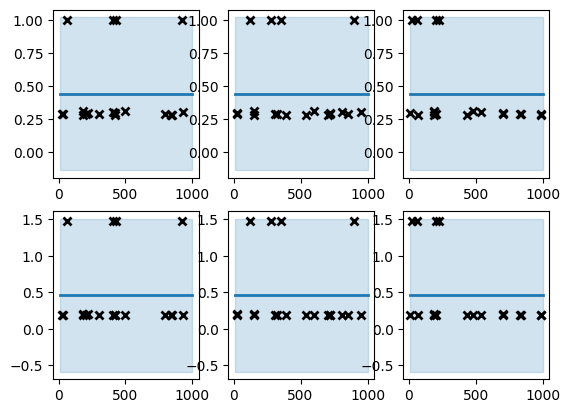

x_best =  [408.96117577 812.44913183 186.18848699]
acq_best =  [ 7.31543961e-18 -1.45977785e-17]
C = [408.96117577 812.44913183 186.18848699]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 22036686848.0000 - mae: 217182.6719 - mse: 118355681280.0000 - val_loss: 12089874432.0000 - val_mae: 164193.1562 - val_mse: 64932626432.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 11815028736.0000 - mae: 166523.3125 - mse: 63456489472.0000 - val_loss: 10277801984.0000 - val_mae: 155862.2031 - val_mse: 55200227328.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 11155065856.0000 - mae: 161829.0312 - mse: 59911856128.0000 - val_loss: 10623664128.0000 - val_mae: 157308.2344 - val_mse: 57057804288.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 10931828736.0000 - mae: 161236.7188 - mse: 58712936448.0000 - val_loss: 10234637312.0000 - val_mae: 160608.8594 - val_mse: 54968369152.0000
Epoch

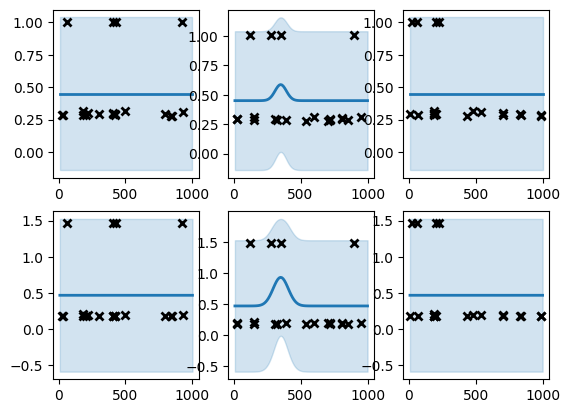

x_best =  [839.55093979 704.3230336  985.67267511]
acq_best =  [ 1.78621907e-12 -1.52235155e-17]
C = [839.55093979 704.3230336  985.67267511]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 416980271104.0000 - mae: 538371.5000 - mse: 423040778240.0000 - val_loss: 423882227712.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 416979746816.0000 - mae: 538371.7500 - mse: 423041007616.0000 - val_loss: 423882227712.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 416980205568.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 423882227712.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 416980140032.0000 - mae: 538371.3125 - mse: 423040614400.0000 - val_loss: 423882227712.0000 - val_mae: 542668.6250 - val_mse: 430042

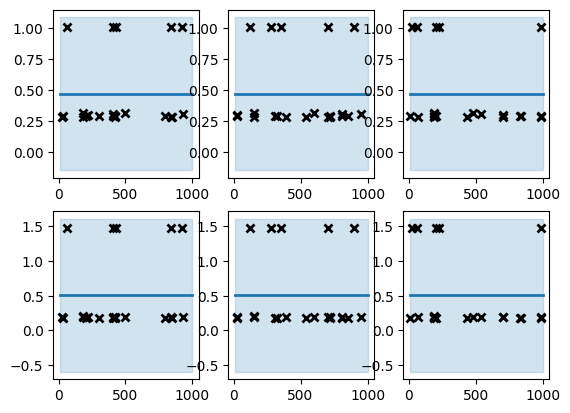

x_best =  [409.24448143 812.24863856 186.19810308]
acq_best =  [4.83471120e-13 5.52347818e-18]
C = [409.24448143 812.24863856 186.19810308]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 20019283968.0000 - mae: 207715.5938 - mse: 107514888192.0000 - val_loss: 11218266112.0000 - val_mae: 159557.1875 - val_mse: 60248240128.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 11502283776.0000 - mae: 164253.8750 - mse: 61773557760.0000 - val_loss: 11060566016.0000 - val_mae: 168572.4531 - val_mse: 59401224192.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 10872501248.0000 - mae: 161030.2656 - mse: 58391285760.0000 - val_loss: 10149105664.0000 - val_mae: 156591.3906 - val_mse: 54506188800.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 10883894272.0000 - mae: 161243.8125 - mse: 58452459520.0000 - val_loss: 10005213184.0000 - val_mae: 152270.1875 - val_mse: 53733433344.0000
Epoch 5

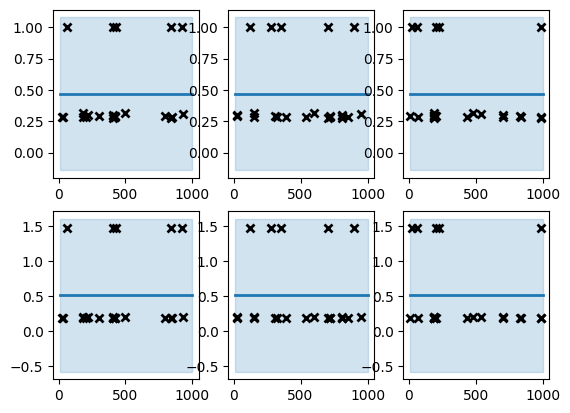

x_best =  [795.18462505  27.55093046 833.52841975]
acq_best =  [ 7.43111687e-14 -1.71095246e-17]
C = [795.18462505  27.55093046 833.52841975]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 106620796928.0000 - mae: 227555.6406 - mse: 127914680320.0000 - val_loss: 76606029824.0000 - val_mae: 187177.0781 - val_mse: 91905482752.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 58543812608.0000 - mae: 168908.3125 - mse: 70235938816.0000 - val_loss: 49901916160.0000 - val_mae: 168596.7969 - val_mse: 59868073984.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 49987211264.0000 - mae: 161247.3594 - mse: 59970437120.0000 - val_loss: 45413036032.0000 - val_mae: 155070.0625 - val_mse: 54482710528.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 49224880128.0000 - mae: 161214.9688 - mse: 59055886336.0000 - val_loss: 45091741696.0000 - val_mae: 155228.9219 - val_mse: 54097240064.0000
Epoc

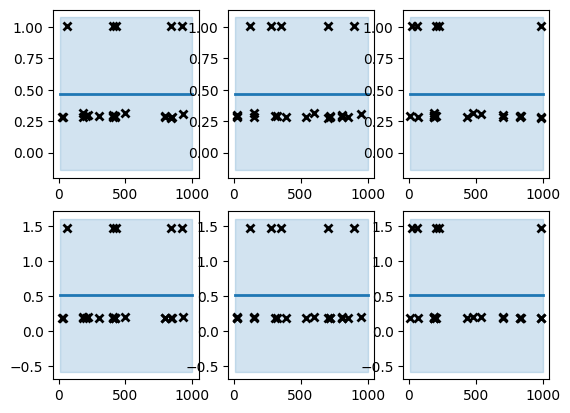

x_best =  [795.11200033  27.51428955 833.53365096]
acq_best =  [1.26932655e-52 1.29410509e-92]
C = [795.11200033  27.51428955 833.53365096]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 112733839360.0000 - mae: 233578.0625 - mse: 135247781888.0000 - val_loss: 83764690944.0000 - val_mae: 208903.7656 - val_mse: 100493213696.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 62620332032.0000 - mae: 172536.5625 - mse: 75126177792.0000 - val_loss: 49692073984.0000 - val_mae: 158011.2188 - val_mse: 59615961088.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 50946191360.0000 - mae: 162345.2969 - mse: 61120495616.0000 - val_loss: 52452331520.0000 - val_mae: 165290.2500 - val_mse: 62927466496.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 48861728768.0000 - mae: 159194.0781 - mse: 58619809792.0000 - val_loss: 45698596864.0000 - val_mae: 155587.6406 - val_mse: 54824939520.0000
Epoch

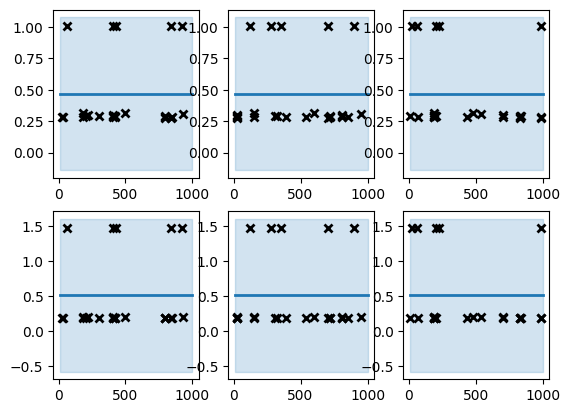

x_best =  [846.24163682 543.07969408 435.43695996]
acq_best =  [ 3.73726456e-15 -1.69909044e-17]
C = [846.24163682 543.07969408 435.43695996]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 46740389888.0000 - mae: 206527.0000 - mse: 107340857344.0000 - val_loss: 25679523840.0000 - val_mae: 155668.4375 - val_mse: 58973790208.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 26687858688.0000 - mae: 163679.4219 - mse: 61289484288.0000 - val_loss: 27685914624.0000 - val_mae: 162757.1094 - val_mse: 63581532160.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 25518962688.0000 - mae: 161745.5781 - mse: 58605047808.0000 - val_loss: 24964853760.0000 - val_mae: 152816.4219 - val_mse: 57332518912.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 25495343104.0000 - mae: 161112.7969 - mse: 58550771712.0000 - val_loss: 24757161984.0000 - val_mae: 157625.1719 - val_mse: 56855531520.0000
Epoch

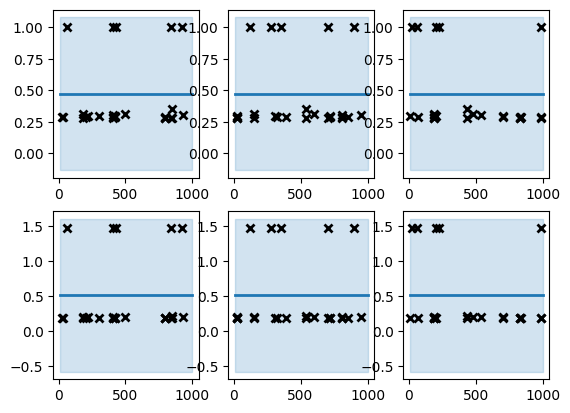

x_best =  [205.79062046 323.88323356 837.84917412]
acq_best =  [ 3.23723969e-08 -1.65196728e-17]
C = [205.79062046 323.88323356 837.84917412]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 354444804096.0000 - mae: 538371.4375 - mse: 423040778240.0000 - val_loss: 360311652352.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 354444869632.0000 - mae: 538371.6250 - mse: 423040745472.0000 - val_loss: 360311652352.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 354444869632.0000 - mae: 538371.6875 - mse: 423040745472.0000 - val_loss: 360311652352.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 354444869632.0000 - mae: 538371.5625 - mse: 423040548864.0000 - val_loss: 360311652352.0000 - val_mae: 542668.6250 - val_mse: 43004293

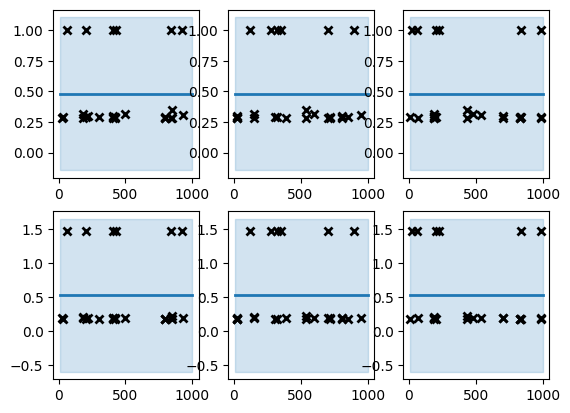

x_best =  [681.67404402 685.32173144 892.53382647]
acq_best =  [0.12433338 0.22427699]
C = [681.67404402 685.32173144 892.53382647]
Epoch 1/6
517/517 [==============================] - 7s 10ms/step - loss: 96083329024.0000 - mae: 205746.1406 - mse: 107652120576.0000 - val_loss: 56004014080.0000 - val_mae: 167756.8594 - val_mse: 62746988544.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 55562375168.0000 - mae: 164187.3438 - mse: 62252228608.0000 - val_loss: 50091044864.0000 - val_mae: 155139.4062 - val_mse: 56122126336.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 52619747328.0000 - mae: 160171.5625 - mse: 58955296768.0000 - val_loss: 49122045952.0000 - val_mae: 158264.5625 - val_mse: 55036432384.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 51030851584.0000 - mae: 158677.5156 - mse: 57175166976.0000 - val_loss: 47950135296.0000 - val_mae: 155399.1875 - val_mse: 53723418624.0000
Epoch 5/6
517/

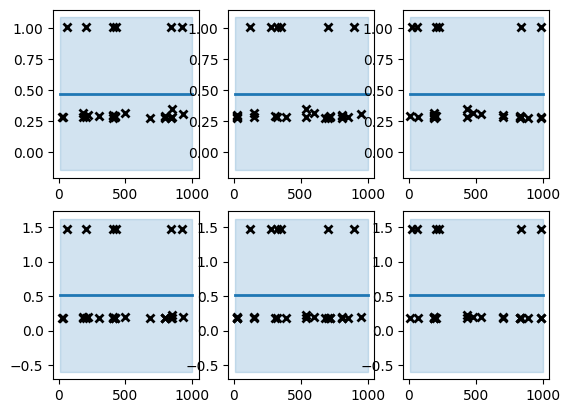

x_best =  [656.49530307  96.02010158  71.68140179]
acq_best =  [0.1225448  0.22080862]
C = [656.49530307  96.02010158  71.68140179]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 9037532160.0000 - mae: 224736.1719 - mse: 126075920384.0000 - val_loss: 6006768640.0000 - val_mae: 181130.5312 - val_mse: 83795615744.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 4847530496.0000 - mae: 168423.7344 - mse: 67623669760.0000 - val_loss: 4299082240.0000 - val_mae: 157429.8594 - val_mse: 59972669440.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 4255684864.0000 - mae: 161356.7969 - mse: 59367190528.0000 - val_loss: 4036495872.0000 - val_mae: 163776.5312 - val_mse: 56309338112.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 4134082816.0000 - mae: 159708.4688 - mse: 57670729728.0000 - val_loss: 3924976384.0000 - val_mae: 152001.3750 - val_mse: 54753722368.0000
Epoch 5/6
517/517 [====

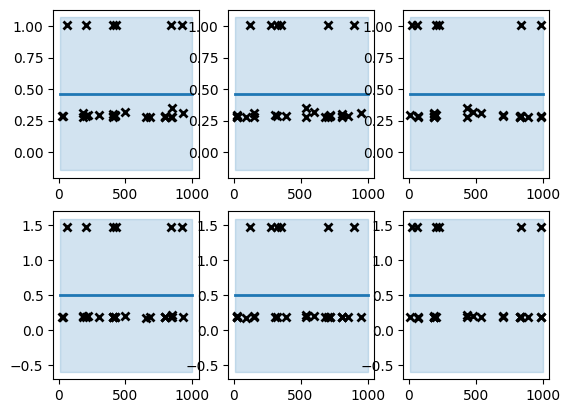

x_best =  [676.54555351 411.28922934 635.06314148]
acq_best =  [0.12076441 0.21752411]
C = [676.54555351 411.28922934 635.06314148]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 69285527552.0000 - mae: 209569.0781 - mse: 109099868160.0000 - val_loss: 38918258688.0000 - val_mae: 167894.8906 - val_mse: 61282226176.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 39562338304.0000 - mae: 164736.7500 - mse: 62296473600.0000 - val_loss: 35308961792.0000 - val_mae: 154972.4531 - val_mse: 55598907392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 37044224000.0000 - mae: 161165.4375 - mse: 58331303936.0000 - val_loss: 36074840064.0000 - val_mae: 159960.2500 - val_mse: 56804864000.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 36775563264.0000 - mae: 160117.8281 - mse: 57908256768.0000 - val_loss: 39187288064.0000 - val_mae: 163447.8125 - val_mse: 61705859072.0000
Epoch 5/6
517/5

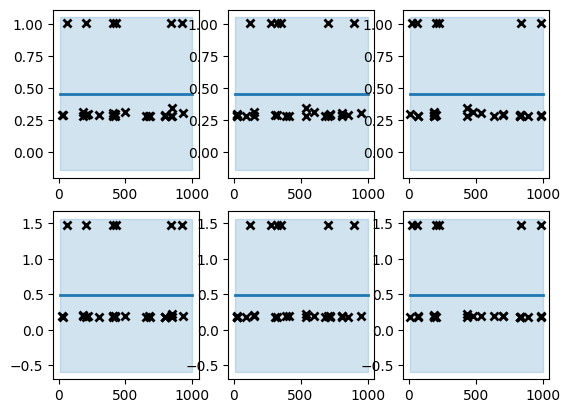

x_best =  [678.45457796 546.32578055 994.86981521]
acq_best =  [0.11905918 0.21429424]
C = [678.45457796 546.32578055 994.86981521]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 104134909952.0000 - mae: 205083.3750 - mse: 104671715328.0000 - val_loss: 63128662016.0000 - val_mae: 176776.8438 - val_mse: 63454011392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 61089771520.0000 - mae: 164480.0312 - mse: 61404635136.0000 - val_loss: 56417988608.0000 - val_mae: 155755.2500 - val_mse: 56708784128.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 58628464640.0000 - mae: 161740.6875 - mse: 58930647040.0000 - val_loss: 54723346432.0000 - val_mae: 157264.2344 - val_mse: 55005388800.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 57241985024.0000 - mae: 160029.7969 - mse: 57537028096.0000 - val_loss: 53912633344.0000 - val_mae: 152690.3125 - val_mse: 54190493696.0000
Epoch 5/6
517/

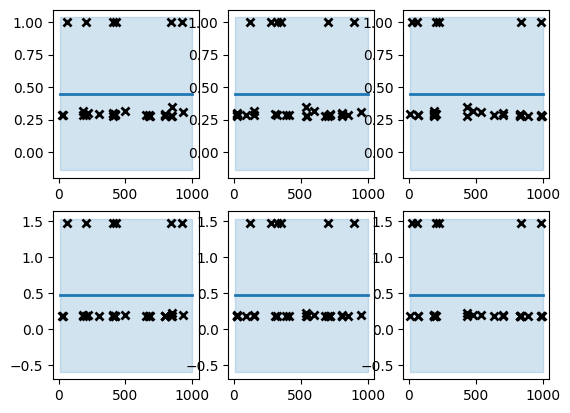

x_best =  [195.74148636 511.97454431 596.13805421]
acq_best =  [0.11741874 0.21119214]
C = [195.74148636 511.97454431 596.13805421]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 75847630848.0000 - mae: 227468.1250 - mse: 127231262720.0000 - val_loss: 57387708416.0000 - val_mae: 193719.6406 - val_mse: 96265486336.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 41399128064.0000 - mae: 169020.1406 - mse: 69445238784.0000 - val_loss: 33957756928.0000 - val_mae: 156903.2344 - val_mse: 56962662400.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 35217113088.0000 - mae: 161469.2344 - mse: 59075149824.0000 - val_loss: 35611930624.0000 - val_mae: 155410.6094 - val_mse: 59737473024.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 34554077184.0000 - mae: 159881.1250 - mse: 57962971136.0000 - val_loss: 32206977024.0000 - val_mae: 153374.1250 - val_mse: 54025785344.0000
Epoch 5/6
517/5

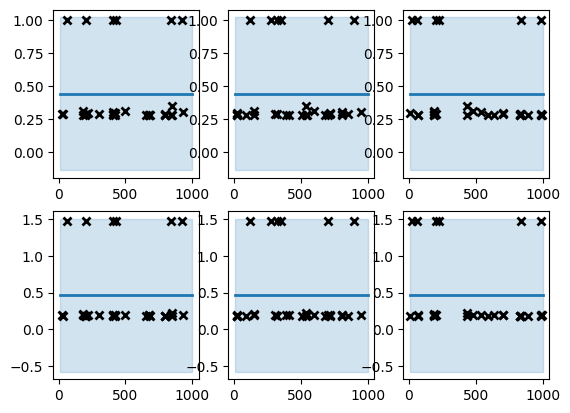

x_best =  [982.29462068 763.64099404 966.02012631]
acq_best =  [0.11583628 0.20824386]
C = [982.29462068 763.64099404 966.02012631]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 101619163136.0000 - mae: 204061.7344 - mse: 105193373696.0000 - val_loss: 58227773440.0000 - val_mae: 162516.7344 - val_mse: 60275752960.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 58939650048.0000 - mae: 163599.9062 - mse: 61012676608.0000 - val_loss: 56946401280.0000 - val_mae: 154887.6875 - val_mse: 58949337088.0000
Epoch 3/6
517/517 [==============================] - 6s 12ms/step - loss: 56783409152.0000 - mae: 161099.7656 - mse: 58780590080.0000 - val_loss: 61363830784.0000 - val_mae: 171215.6875 - val_mse: 63522152448.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 56641069056.0000 - mae: 160661.0938 - mse: 58633256960.0000 - val_loss: 69088157696.0000 - val_mae: 199788.4844 - val_mse: 71518134272.0000
Epoch 5/6
5

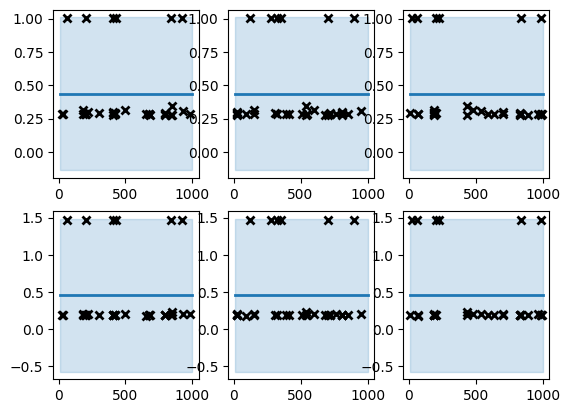

x_best =  [637.88358474 524.89392609 574.13722263]
acq_best =  [0.11427597 0.20531062]
C = [637.88358474 524.89392609 574.13722263]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 61050089472.0000 - mae: 206514.8125 - mse: 106333216768.0000 - val_loss: 36873048064.0000 - val_mae: 162511.2031 - val_mse: 64223121408.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 35187568640.0000 - mae: 163696.6250 - mse: 61287444480.0000 - val_loss: 32536727552.0000 - val_mae: 164850.2188 - val_mse: 56670359552.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 33987246080.0000 - mae: 161960.0625 - mse: 59196764160.0000 - val_loss: 31608330240.0000 - val_mae: 156320.5469 - val_mse: 55053361152.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 33412524032.0000 - mae: 160234.1562 - mse: 58195787776.0000 - val_loss: 33842008064.0000 - val_mae: 156074.8594 - val_mse: 58943852544.0000
Epoch 5/6
517/5

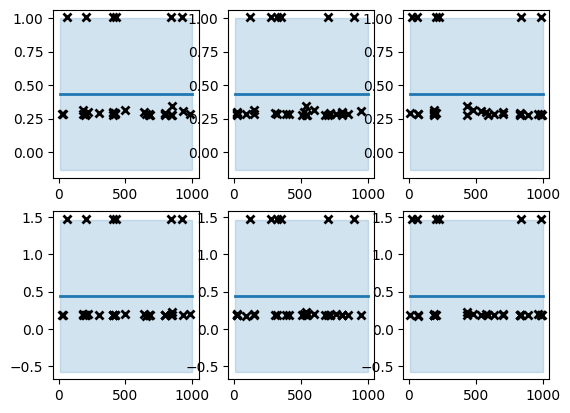

x_best =  [525.47106052 999.79727725 614.41791043]
acq_best =  [0.11265731 0.2025282 ]
C = [525.47106052 999.79727725 614.41791043]
Epoch 1/6
517/517 [==============================] - 3s 6ms/step - loss: 259924213760.0000 - mae: 538371.3125 - mse: 423040679936.0000 - val_loss: 264226750464.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 259924230144.0000 - mae: 538371.5000 - mse: 423040942080.0000 - val_loss: 264226750464.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 259924361216.0000 - mae: 538371.6875 - mse: 423040712704.0000 - val_loss: 264226750464.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 9ms/step - loss: 259924361216.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 264226750464.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


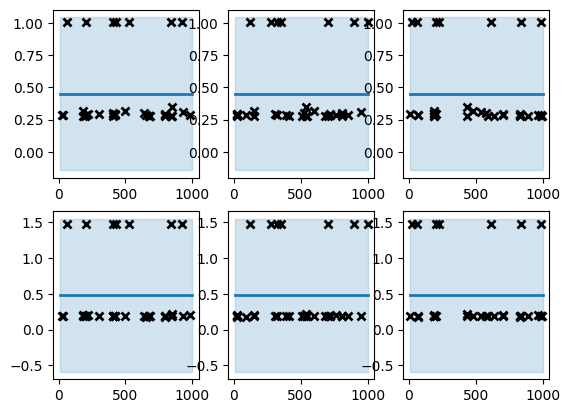

x_best =  [437.19809824 314.30510979 561.13847364]
acq_best =  [0.11832211 0.21272327]
C = [437.19809824 314.30510979 561.13847364]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 237384974336.0000 - mae: 538371.3750 - mse: 423040745472.0000 - val_loss: 241314234368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 237384892416.0000 - mae: 538371.5000 - mse: 423040450560.0000 - val_loss: 241314234368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 237385007104.0000 - mae: 538371.5625 - mse: 423040614400.0000 - val_loss: 241314234368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 237384925184.0000 - mae: 538371.6250 - mse: 423040876544.0000 - val_loss: 241314234368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


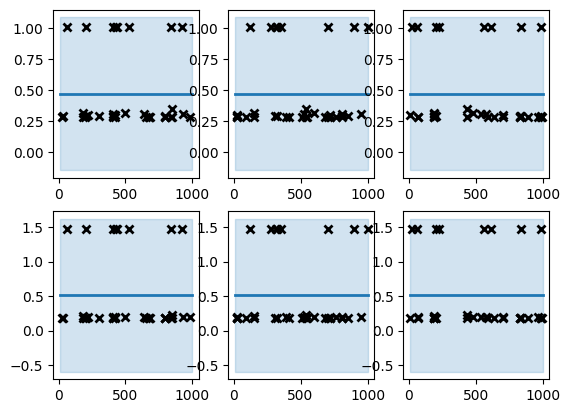

x_best =  [529.75361362 960.48900822 700.39133658]
acq_best =  [0.12300174 0.22115241]
C = [529.75361362 960.48900822 700.39133658]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 76022587392.0000 - mae: 209507.7031 - mse: 108542828544.0000 - val_loss: 42246103040.0000 - val_mae: 156501.8438 - val_mse: 60317634560.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 42296950784.0000 - mae: 163132.3438 - mse: 60390223872.0000 - val_loss: 39758184448.0000 - val_mae: 154147.0781 - val_mse: 56765472768.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 40441692160.0000 - mae: 160373.1250 - mse: 57741365248.0000 - val_loss: 40248967168.0000 - val_mae: 154996.9062 - val_mse: 57466175488.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 39798505472.0000 - mae: 158616.4844 - mse: 56823033856.0000 - val_loss: 39280349184.0000 - val_mae: 153424.0781 - val_mse: 56083214336.0000
Epoch 5/6
517/5

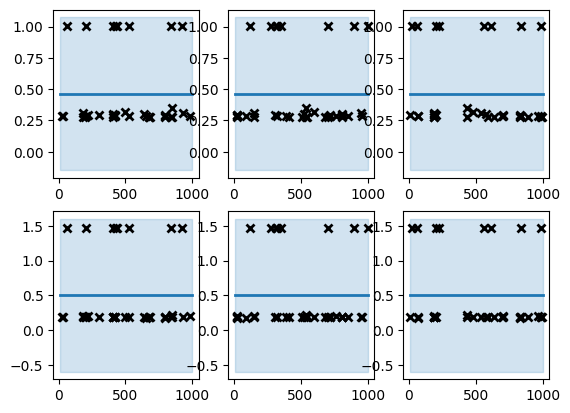

x_best =  [754.87077244 827.90658158  67.73223703]
acq_best =  [0.12166462 0.21871088]
C = [754.87077244 827.90658158  67.73223703]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 7170628096.0000 - mae: 206005.2031 - mse: 105864216576.0000 - val_loss: 4065340928.0000 - val_mae: 155676.7812 - val_mse: 60018458624.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 4152389120.0000 - mae: 164444.6875 - mse: 61303525376.0000 - val_loss: 4120001024.0000 - val_mae: 163766.3750 - val_mse: 60825341952.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 3972898304.0000 - mae: 161623.8750 - mse: 58653560832.0000 - val_loss: 4010171136.0000 - val_mae: 162401.4688 - val_mse: 59203858432.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 3991392512.0000 - mae: 161943.3750 - mse: 58926624768.0000 - val_loss: 3832429312.0000 - val_mae: 162232.4688 - val_mse: 56579649536.0000
Epoch 5/6
517/517 [==

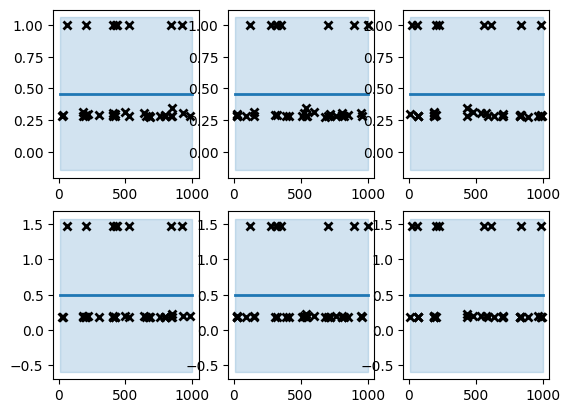

x_best =  [592.02255447 731.14756993 694.42297422]
acq_best =  [0.12037084 0.21634802]
C = [592.02255447 731.14756993 694.42297422]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 77186408448.0000 - mae: 211464.4062 - mse: 111151472640.0000 - val_loss: 43629645824.0000 - val_mae: 163776.2031 - val_mse: 62828408832.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 42769432576.0000 - mae: 164568.0156 - mse: 61589708800.0000 - val_loss: 37780008960.0000 - val_mae: 154760.4844 - val_mse: 54404665344.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 40960647168.0000 - mae: 161617.8125 - mse: 58984964096.0000 - val_loss: 37201051648.0000 - val_mae: 155455.8281 - val_mse: 53570945024.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 40025440256.0000 - mae: 160736.0938 - mse: 57638162432.0000 - val_loss: 40078483456.0000 - val_mae: 157138.8125 - val_mse: 57714581504.0000
Epoch 5/6
517

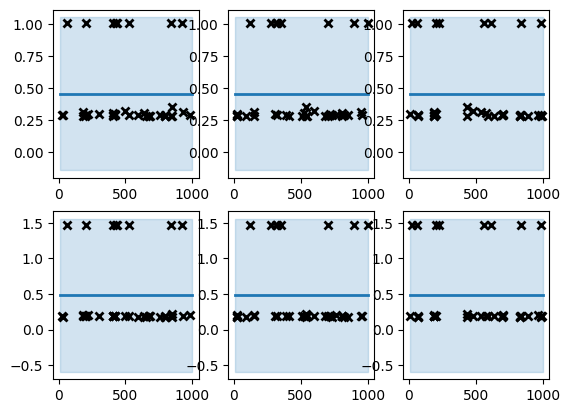

x_best =  [522.76490184 902.7935365  809.27589293]
acq_best =  [0.11906722 0.21403928]
C = [522.76490184 902.7935365  809.27589293]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 86383591424.0000 - mae: 207372.1094 - mse: 106741547008.0000 - val_loss: 50438881280.0000 - val_mae: 169454.8906 - val_mse: 62325719040.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 48941662208.0000 - mae: 162712.9219 - mse: 60475678720.0000 - val_loss: 45243772928.0000 - val_mae: 157338.0625 - val_mse: 55906308096.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 47585136640.0000 - mae: 161820.4375 - mse: 58799403008.0000 - val_loss: 46565806080.0000 - val_mae: 154320.2188 - val_mse: 57539915776.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 47070793728.0000 - mae: 160902.7969 - mse: 58163863552.0000 - val_loss: 46964051968.0000 - val_mae: 154530.2188 - val_mse: 58032005120.0000
Epoch 5/6
517/5

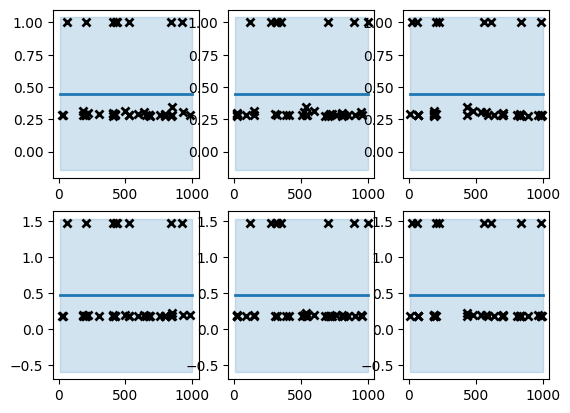

x_best =  [278.53459135 152.52631524  58.71823823]
acq_best =  [0.11782788 0.21179773]
C = [278.53459135 152.52631524  58.71823823]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 7628906496.0000 - mae: 231313.0625 - mse: 129920122880.0000 - val_loss: 5441679872.0000 - val_mae: 188992.5469 - val_mse: 92671238144.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 4078360320.0000 - mae: 169513.9531 - mse: 69453553664.0000 - val_loss: 3415089408.0000 - val_mae: 165779.3281 - val_mse: 58157801472.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 3515652864.0000 - mae: 161899.3750 - mse: 59870494720.0000 - val_loss: 3173125120.0000 - val_mae: 155893.9219 - val_mse: 54037200896.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 3416488960.0000 - mae: 160549.3281 - mse: 58181713920.0000 - val_loss: 3499651072.0000 - val_mae: 158227.1094 - val_mse: 59598065664.0000
Epoch 5/6
517/517 [====

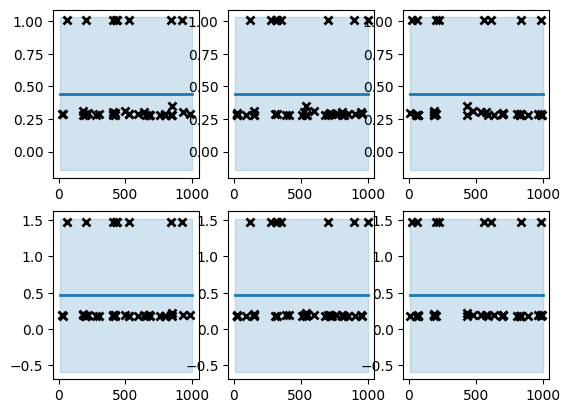

x_best =  [940.93391058 305.31028621 979.02578097]
acq_best =  [0.11664979 0.20962169]
C = [940.93391058 305.31028621 979.02578097]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 104253538304.0000 - mae: 206577.6094 - mse: 106486751232.0000 - val_loss: 58714349568.0000 - val_mae: 158430.0156 - val_mse: 59972096000.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 60874485760.0000 - mae: 164699.3281 - mse: 62178508800.0000 - val_loss: 53262974976.0000 - val_mae: 157732.1406 - val_mse: 54403899392.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 57871065088.0000 - mae: 162091.0625 - mse: 59110711296.0000 - val_loss: 54515802112.0000 - val_mae: 153080.7656 - val_mse: 55683584000.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57347653632.0000 - mae: 161350.5000 - mse: 58576109568.0000 - val_loss: 52326260736.0000 - val_mae: 153753.3438 - val_mse: 53447139328.0000
Epoch 5/6
517/

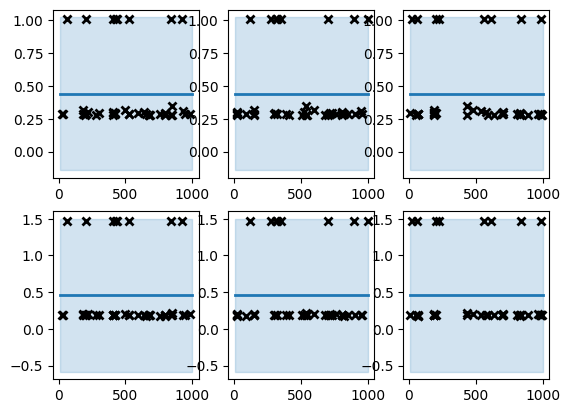

x_best =  [151.92835877 614.1148084  487.23358658]
acq_best =  [0.11545933 0.20745166]
C = [151.92835877 614.1148084  487.23358658]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 63064760320.0000 - mae: 229442.9531 - mse: 129433862144.0000 - val_loss: 46610505728.0000 - val_mae: 197513.0781 - val_mse: 95663153152.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 34128179200.0000 - mae: 170175.2344 - mse: 70044426240.0000 - val_loss: 27782848512.0000 - val_mae: 156273.9062 - val_mse: 57021280256.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 29612154880.0000 - mae: 163966.4062 - mse: 60775735296.0000 - val_loss: 26420293632.0000 - val_mae: 157321.5312 - val_mse: 54224785408.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 28329580544.0000 - mae: 160350.0469 - mse: 58143424512.0000 - val_loss: 26329638912.0000 - val_mae: 153381.3906 - val_mse: 54038732800.0000
Epoch 5/6
517/5

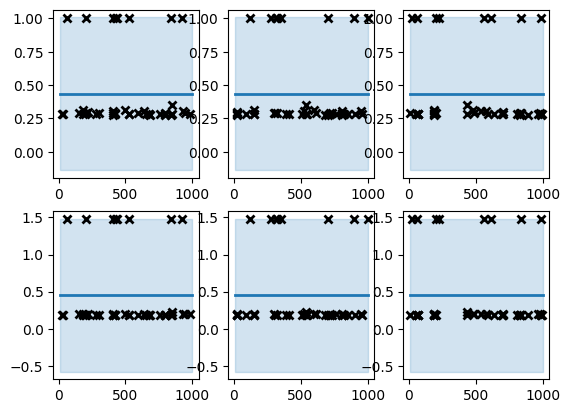

x_best =  [378.30093219 392.48429577 314.96059175]
acq_best =  [0.11430012 0.20533178]
C = [378.30093219 392.48429577 314.96059175]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 38915448832.0000 - mae: 223292.1250 - mse: 123555954688.0000 - val_loss: 25068861440.0000 - val_mae: 184765.1875 - val_mse: 79593037824.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 19766530048.0000 - mae: 163533.2500 - mse: 62758248448.0000 - val_loss: 19864033280.0000 - val_mae: 163066.1562 - val_mse: 63067795456.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 18436755456.0000 - mae: 160575.2500 - mse: 58536202240.0000 - val_loss: 18543796224.0000 - val_mae: 154386.7031 - val_mse: 58876067840.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 18220904448.0000 - mae: 159747.0938 - mse: 57850916864.0000 - val_loss: 17853833216.0000 - val_mae: 152735.9844 - val_mse: 56685436928.0000
Epoch 5/6
517/5

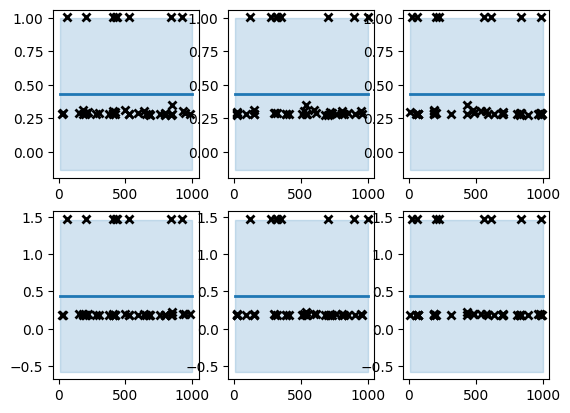

x_best =  [804.75187684 573.28535914 332.49249049]
acq_best =  [0.11321234 0.20334737]
C = [804.75187684 573.28535914 332.49249049]
Epoch 1/6
517/517 [==============================] - 7s 10ms/step - loss: 34479316992.0000 - mae: 202879.0469 - mse: 103698898944.0000 - val_loss: 22921285632.0000 - val_mae: 166897.2188 - val_mse: 68937244672.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 20574674944.0000 - mae: 164632.9844 - mse: 61879644160.0000 - val_loss: 18842068992.0000 - val_mae: 164823.7031 - val_mse: 56668651520.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 19800139776.0000 - mae: 162849.4375 - mse: 59550171136.0000 - val_loss: 18571208704.0000 - val_mae: 156181.9219 - val_mse: 55854059520.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 19447224320.0000 - mae: 160858.9219 - mse: 58488709120.0000 - val_loss: 19189102592.0000 - val_mae: 155983.8281 - val_mse: 57712422912.0000
Epoch 5/6
517/

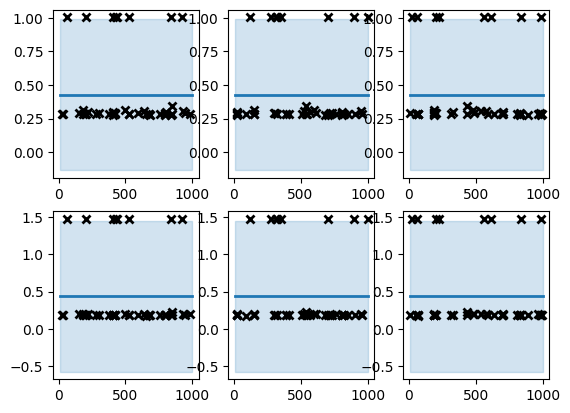

x_best =  [272.15408895 433.18938672 409.64824711]
acq_best =  [0.11205847 0.20135492]
C = [272.15408895 433.18938672 409.64824711]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 50692108288.0000 - mae: 223374.3750 - mse: 123745001472.0000 - val_loss: 32999274496.0000 - val_mae: 172398.1562 - val_mse: 80554729472.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 26168133632.0000 - mae: 164385.0312 - mse: 63879081984.0000 - val_loss: 24414945280.0000 - val_mae: 155063.2500 - val_mse: 59599405056.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 24721344512.0000 - mae: 163838.9844 - mse: 60347301888.0000 - val_loss: 22290802688.0000 - val_mae: 158155.6094 - val_mse: 54414110720.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 23871500288.0000 - mae: 160779.7188 - mse: 58272743424.0000 - val_loss: 22159730688.0000 - val_mae: 152941.6562 - val_mse: 54094147584.0000
Epoch 5/6
517/5

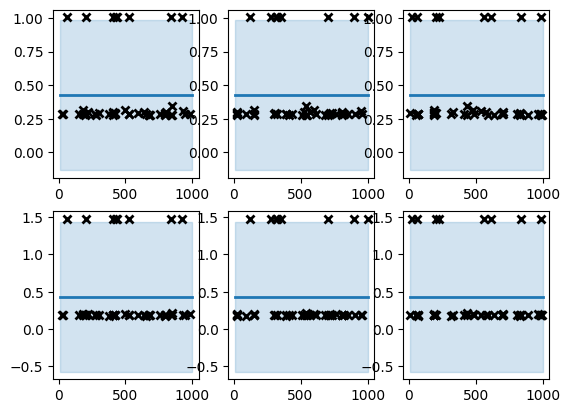

x_best =  [669.79589049 802.00330917 430.00669569]
acq_best =  [0.11101202 0.19947201]
C = [669.79589049 802.00330917 430.00669569]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 44473196544.0000 - mae: 203469.8438 - mse: 103423893504.0000 - val_loss: 26922233856.0000 - val_mae: 172468.4375 - val_mse: 62608457728.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 26168780800.0000 - mae: 163161.9219 - mse: 60856328192.0000 - val_loss: 23935643648.0000 - val_mae: 154079.5312 - val_mse: 55663071232.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 25320421376.0000 - mae: 161447.3906 - mse: 58883407872.0000 - val_loss: 23757561856.0000 - val_mae: 153312.2344 - val_mse: 55248924672.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 24666658816.0000 - mae: 159344.1875 - mse: 57363070976.0000 - val_loss: 25342234624.0000 - val_mae: 155677.1875 - val_mse: 58934145024.0000
Epoch 5/6
517

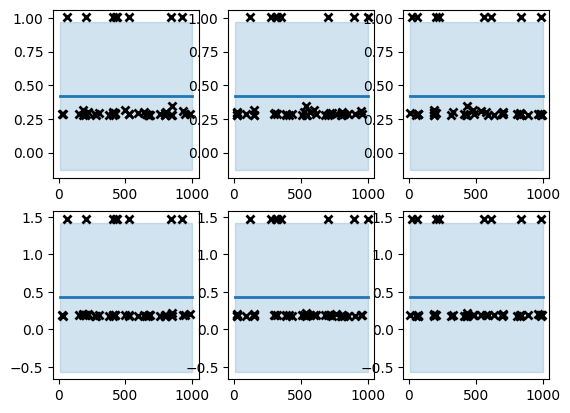

x_best =  [720.35471893 104.88747053 924.25673346]
acq_best =  [0.11002185 0.19764867]
C = [720.35471893 104.88747053 924.25673346]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 115725918208.0000 - mae: 224431.6562 - mse: 125209526272.0000 - val_loss: 66514436096.0000 - val_mae: 174369.5938 - val_mse: 71965122560.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 59300122624.0000 - mae: 164764.8281 - mse: 64159584256.0000 - val_loss: 52336807936.0000 - val_mae: 155872.3125 - val_mse: 56625643520.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 54477418496.0000 - mae: 161075.6562 - mse: 58941669376.0000 - val_loss: 50789445632.0000 - val_mae: 154464.2188 - val_mse: 54951489536.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 53976268800.0000 - mae: 160674.2344 - mse: 58399490048.0000 - val_loss: 50822160384.0000 - val_mae: 152756.0312 - val_mse: 54986895360.0000
Epoch 5/6
517/

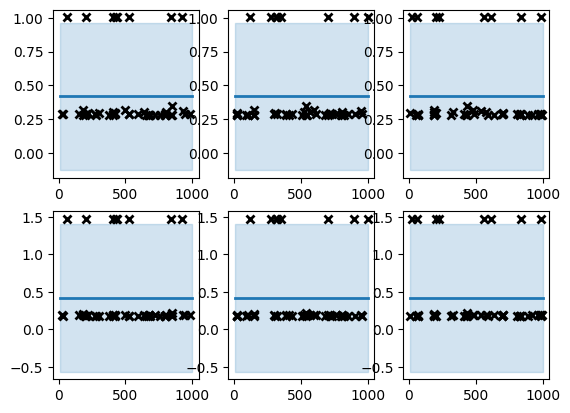

x_best =  [814.1990309  391.73752602 521.30682306]
acq_best =  [0.10904695 0.19584027]
C = [814.1990309  391.73752602 521.30682306]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 56228933632.0000 - mae: 208512.2969 - mse: 107860983808.0000 - val_loss: 32146921472.0000 - val_mae: 158170.2031 - val_mse: 61665738752.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 31607826432.0000 - mae: 163148.3594 - mse: 60631547904.0000 - val_loss: 31347603456.0000 - val_mae: 158850.0781 - val_mse: 60132446208.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 30390358016.0000 - mae: 160506.8750 - mse: 58296197120.0000 - val_loss: 28482734080.0000 - val_mae: 153034.3750 - val_mse: 54636879872.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 29954686976.0000 - mae: 159166.7031 - mse: 57460436992.0000 - val_loss: 28507965440.0000 - val_mae: 161436.4531 - val_mse: 54685261824.0000
Epoch 5/6
517/5

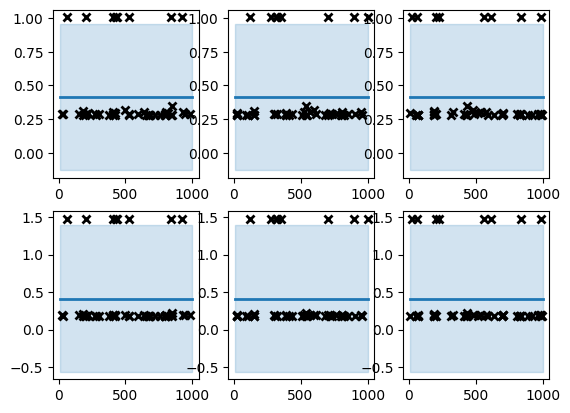

x_best =  [632.25170541 548.8241725  307.79627067]
acq_best =  [0.10804587 0.19409566]
C = [632.25170541 548.8241725  307.79627067]
Epoch 1/6
517/517 [==============================] - 2s 4ms/step - loss: 33513512960.0000 - mae: 208420.1562 - mse: 108881403904.0000 - val_loss: 19240726528.0000 - val_mae: 166865.0469 - val_mse: 62510686208.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 18988556288.0000 - mae: 163857.6250 - mse: 61691428864.0000 - val_loss: 17870080000.0000 - val_mae: 162985.9688 - val_mse: 58057617408.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 18228674560.0000 - mae: 161381.0469 - mse: 59222634496.0000 - val_loss: 16758192128.0000 - val_mae: 149949.7656 - val_mse: 54445240320.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 17445267456.0000 - mae: 157768.4688 - mse: 56677474304.0000 - val_loss: 16558187520.0000 - val_mae: 149780.4062 - val_mse: 53795442688.0000
Epoch 5/6
517/5

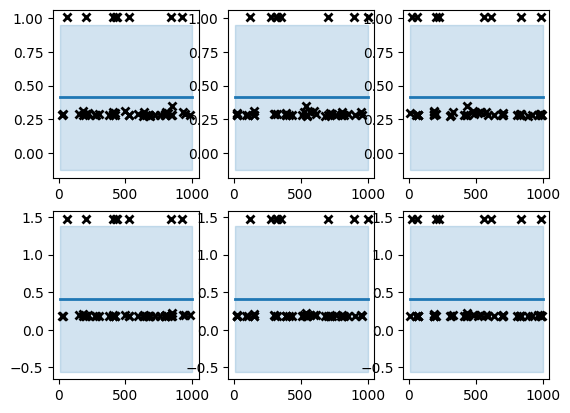

x_best =  [581.88988853 709.70544929 237.41588442]
acq_best =  [0.10714221 0.19240981]
C = [581.88988853 709.70544929 237.41588442]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 24683073536.0000 - mae: 203872.0312 - mse: 103964704768.0000 - val_loss: 17849559040.0000 - val_mae: 205308.2656 - val_mse: 75181817856.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 14705162240.0000 - mae: 163731.5625 - mse: 61937737728.0000 - val_loss: 13334951936.0000 - val_mae: 163254.7500 - val_mse: 56166354944.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 13823393792.0000 - mae: 160043.9219 - mse: 58223693824.0000 - val_loss: 13016467456.0000 - val_mae: 155448.9062 - val_mse: 54824939520.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 13758671872.0000 - mae: 159887.7969 - mse: 57951059968.0000 - val_loss: 12721458176.0000 - val_mae: 154323.4219 - val_mse: 53582364672.0000
Epoch 5/6
517/5

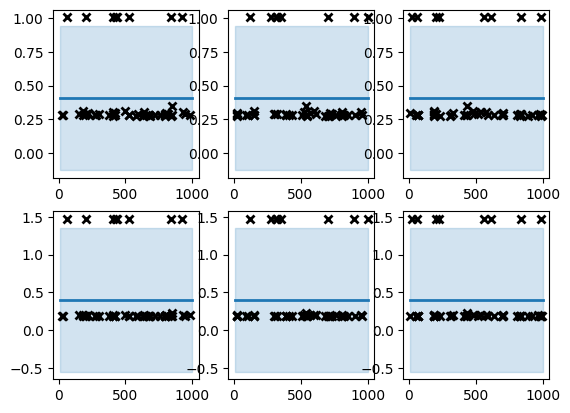

x_best =  [489.40304896 742.05949752 236.11226158]
acq_best =  [0.10625704 0.19075075]
C = [489.40304896 742.05949752 236.11226158]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 38599479296.0000 - mae: 264723.6250 - mse: 163478274048.0000 - val_loss: 16769997824.0000 - val_mae: 175821.5938 - val_mse: 71024754688.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 14779114496.0000 - mae: 164587.9531 - mse: 62592880640.0000 - val_loss: 12868473856.0000 - val_mae: 153981.8125 - val_mse: 54500855808.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 13746359296.0000 - mae: 160626.4219 - mse: 58218930176.0000 - val_loss: 13583756288.0000 - val_mae: 155249.6562 - val_mse: 57530265600.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 13558736896.0000 - mae: 159686.5469 - mse: 57424297984.0000 - val_loss: 12792242176.0000 - val_mae: 151981.6250 - val_mse: 54178004992.0000
Epoch 5/6
517/5

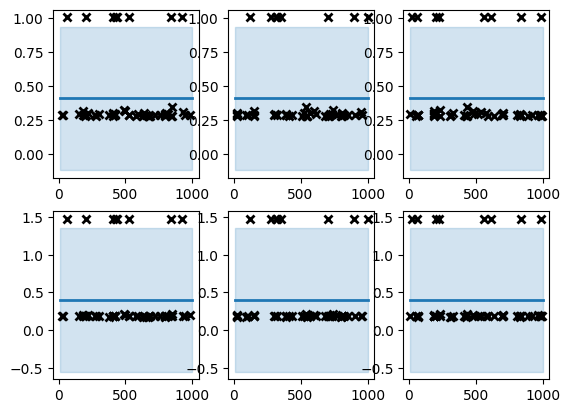

x_best =  [730.18526955  10.47091497  18.84131224]
acq_best =  [0.10523879 0.18904359]
C = [730.18526955  10.47091497  18.84131224]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 2458204672.0000 - mae: 230553.5156 - mse: 130456649728.0000 - val_loss: 1858451968.0000 - val_mae: 191923.1719 - val_mse: 98626863104.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 1434651520.0000 - mae: 173185.2188 - mse: 76134785024.0000 - val_loss: 1246981248.0000 - val_mae: 177919.3906 - val_mse: 66173878272.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 1180203136.0000 - mae: 164359.0469 - mse: 62630383616.0000 - val_loss: 1091928576.0000 - val_mae: 164110.5156 - val_mse: 57945251840.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 1132602112.0000 - mae: 162169.5625 - mse: 60104101888.0000 - val_loss: 1095735168.0000 - val_mae: 161141.4688 - val_mse: 58147442688.0000
Epoch 5/6
517/517 [====

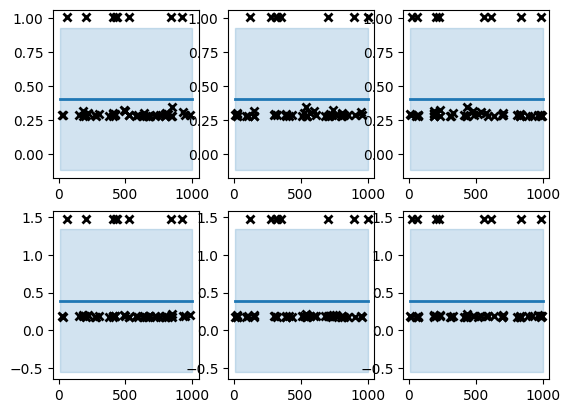

x_best =  [ 16.04686127 544.87691192 751.21260622]
acq_best =  [0.10435947 0.18747829]
C = [ 16.04686127 544.87691192 751.21260622]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 107612626944.0000 - mae: 241544.1719 - mse: 143251472384.0000 - val_loss: 95403737088.0000 - val_mae: 229414.8594 - val_mse: 126999289856.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 91309375488.0000 - mae: 221806.5156 - mse: 121549103104.0000 - val_loss: 87934443520.0000 - val_mae: 216577.0469 - val_mse: 117056372736.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 76292726784.0000 - mae: 201888.2031 - mse: 101559230464.0000 - val_loss: 57535123456.0000 - val_mae: 170304.9844 - val_mse: 76589424640.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 52563714048.0000 - mae: 170857.7969 - mse: 69971574784.0000 - val_loss: 47173099520.0000 - val_mae: 164563.2969 - val_mse: 62795714560.0000
Epoch 5/6


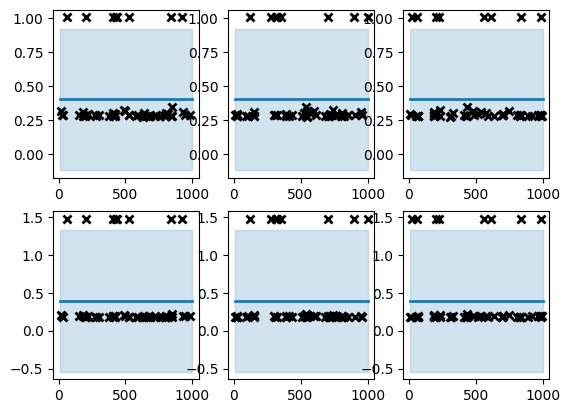

x_best =  [365.91764292 642.33227629 619.17497444]
acq_best =  [0.10341799 0.18586827]
C = [365.91764292 642.33227629 619.17497444]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 71239401472.0000 - mae: 215905.7656 - mse: 115055017984.0000 - val_loss: 40207052800.0000 - val_mae: 170990.0625 - val_mse: 64936226816.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 38504140800.0000 - mae: 164145.0000 - mse: 62185893888.0000 - val_loss: 33333045248.0000 - val_mae: 154323.4688 - val_mse: 53834358784.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 36676087808.0000 - mae: 161699.3594 - mse: 59233480704.0000 - val_loss: 34851856384.0000 - val_mae: 165534.5156 - val_mse: 56287305728.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 35838914560.0000 - mae: 159837.9219 - mse: 57881505792.0000 - val_loss: 32840622080.0000 - val_mae: 154683.1562 - val_mse: 53039075328.0000
Epoch 5/6
517/5

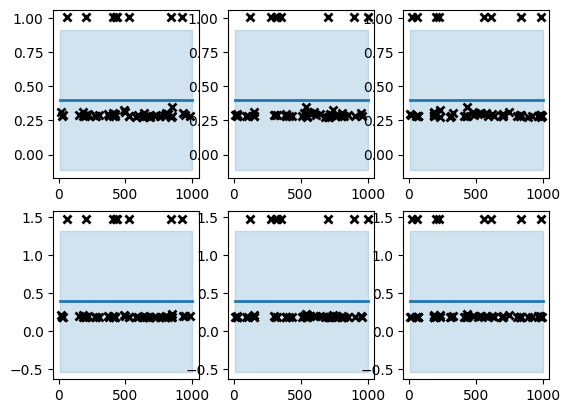

x_best =  [ 54.79944254 628.70835693 475.17561618]
acq_best =  [0.1025669  0.18433297]
C = [ 54.79944254 628.70835693 475.17561618]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 65026498560.0000 - mae: 236151.0312 - mse: 136846729216.0000 - val_loss: 56217120768.0000 - val_mae: 228044.7500 - val_mse: 118307627008.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 44653854720.0000 - mae: 192073.1719 - mse: 93972996096.0000 - val_loss: 30426378240.0000 - val_mae: 170433.2031 - val_mse: 64031494144.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 29629274112.0000 - mae: 162859.7188 - mse: 62354042880.0000 - val_loss: 32063903744.0000 - val_mae: 188598.1719 - val_mse: 67477610496.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 27906199552.0000 - mae: 159839.1562 - mse: 58727866368.0000 - val_loss: 25994045440.0000 - val_mae: 159183.0312 - val_mse: 54703726592.0000
Epoch 5/6
517/

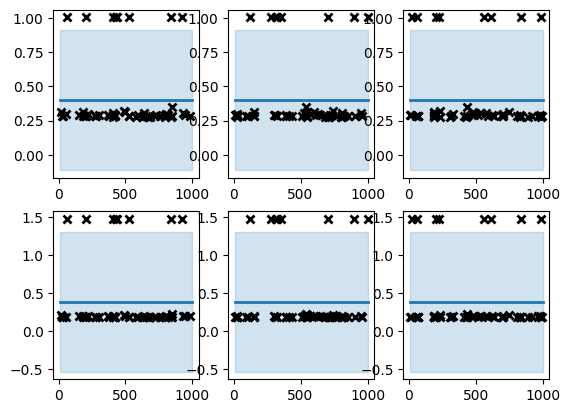

x_best =  [107.43734002 714.31218652 408.38957814]
acq_best =  [0.10171785 0.18285737]
C = [107.43734002 714.31218652 408.38957814]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 53112635392.0000 - mae: 228368.4062 - mse: 130053226496.0000 - val_loss: 36854038528.0000 - val_mae: 188225.5781 - val_mse: 90241916928.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 28520574976.0000 - mae: 169981.5312 - mse: 69836259328.0000 - val_loss: 27307837440.0000 - val_mae: 184399.0000 - val_mse: 66866679808.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 25584687104.0000 - mae: 165875.5156 - mse: 62647296000.0000 - val_loss: 23314284544.0000 - val_mae: 157175.0781 - val_mse: 57087971328.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 24742066176.0000 - mae: 162973.7656 - mse: 60584103936.0000 - val_loss: 24002797568.0000 - val_mae: 170162.4531 - val_mse: 58773852160.0000
Epoch 5/6
517/5

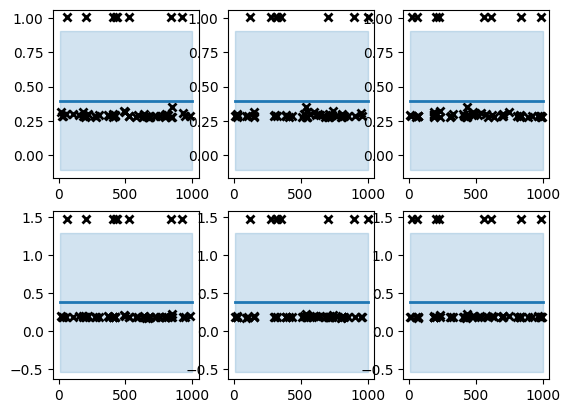

x_best =  [478.95917342 789.75865862 879.16685781]
acq_best =  [0.10089815 0.18141791]
C = [478.95917342 789.75865862 879.16685781]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 95712780288.0000 - mae: 208130.2656 - mse: 108867420160.0000 - val_loss: 61225758720.0000 - val_mae: 194901.0625 - val_mse: 69640454144.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 53776769024.0000 - mae: 163734.1875 - mse: 61167722496.0000 - val_loss: 46771945472.0000 - val_mae: 153375.0625 - val_mse: 53200150528.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 51105419264.0000 - mae: 159543.1094 - mse: 58129186816.0000 - val_loss: 46961127424.0000 - val_mae: 152541.7656 - val_mse: 53415313408.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 50529591296.0000 - mae: 158666.0938 - mse: 57474224128.0000 - val_loss: 48911810560.0000 - val_mae: 163354.9688 - val_mse: 55634087936.0000
Epoch 5/6
517/

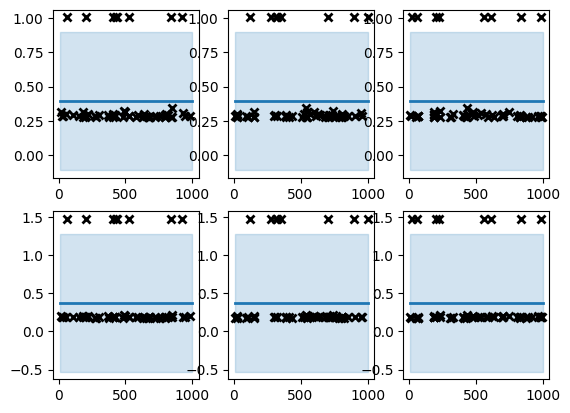

x_best =  [407.07425946 534.94290325 281.95306418]
acq_best =  [0.10015097 0.18003893]
C = [407.07425946 534.94290325 281.95306418]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 32598994944.0000 - mae: 215165.2031 - mse: 115617775616.0000 - val_loss: 21106571264.0000 - val_mae: 198865.3750 - val_mse: 74857742336.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 17709715456.0000 - mae: 164581.7812 - mse: 62810292224.0000 - val_loss: 15686351872.0000 - val_mae: 163123.7656 - val_mse: 55634042880.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 16687315968.0000 - mae: 160934.9844 - mse: 59184209920.0000 - val_loss: 16575351808.0000 - val_mae: 169303.8906 - val_mse: 58787033088.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 16217999360.0000 - mae: 158363.1250 - mse: 57519661056.0000 - val_loss: 15197958144.0000 - val_mae: 156157.1875 - val_mse: 53901901824.0000
Epoch 5/6
517/5

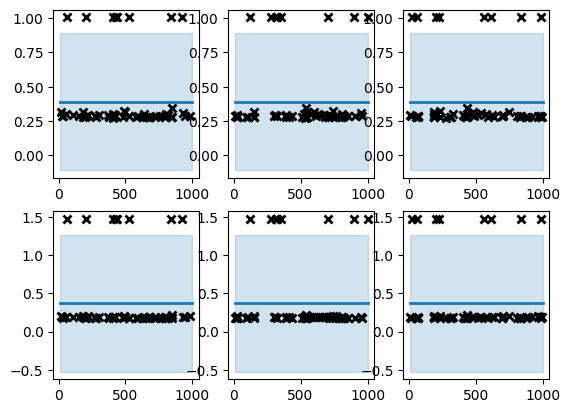

x_best =  [813.61244374  25.53657985 276.92065783]
acq_best =  [0.09943467 0.17868025]
C = [813.61244374  25.53657985 276.92065783]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 36816879616.0000 - mae: 233206.8594 - mse: 132950130688.0000 - val_loss: 25531246592.0000 - val_mae: 188618.9375 - val_mse: 92196282368.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 19772370944.0000 - mae: 169477.0625 - mse: 71400235008.0000 - val_loss: 16578164736.0000 - val_mae: 167507.1406 - val_mse: 59865518080.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 16760738816.0000 - mae: 161583.3750 - mse: 60524814336.0000 - val_loss: 15717609472.0000 - val_mae: 154314.9844 - val_mse: 56757993472.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 16186958848.0000 - mae: 159624.9375 - mse: 58452811776.0000 - val_loss: 15089400832.0000 - val_mae: 152101.9531 - val_mse: 54489432064.0000
Epoch 5/6
517/5

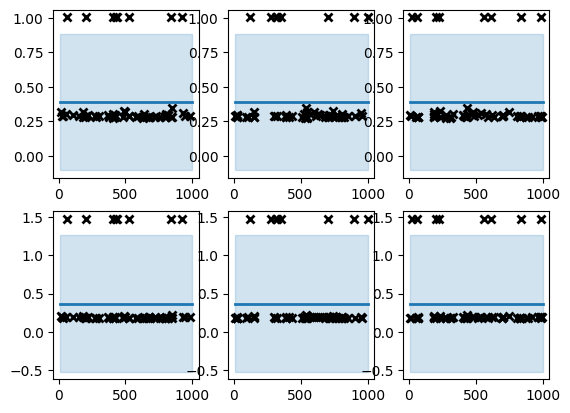

x_best =  [122.9860026  426.07891518 534.64048302]
acq_best =  [0.09867872 0.17735074]
C = [122.9860026  426.07891518 534.64048302]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 103379476480.0000 - mae: 294997.5938 - mse: 193362149376.0000 - val_loss: 59169968128.0000 - val_mae: 207299.2500 - val_mse: 110672068608.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 44815319040.0000 - mae: 181262.0625 - mse: 83822952448.0000 - val_loss: 32312539136.0000 - val_mae: 159150.5000 - val_mse: 60437585920.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 33180282880.0000 - mae: 163503.2656 - mse: 62060654592.0000 - val_loss: 30594586624.0000 - val_mae: 156914.5469 - val_mse: 57224290304.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 31763910656.0000 - mae: 161399.0625 - mse: 59411443712.0000 - val_loss: 30835355648.0000 - val_mae: 162457.1406 - val_mse: 57674629120.0000
Epoch 5/6
517

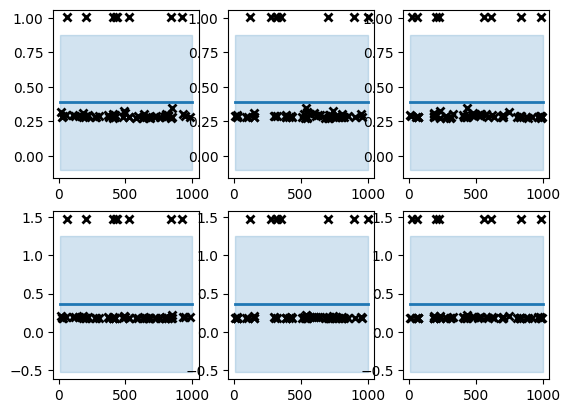

x_best =  [154.61853967 281.25571266 701.75670233]
acq_best =  [0.09795931 0.17601706]
C = [154.61853967 281.25571266 701.75670233]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 94975483904.0000 - mae: 233486.2656 - mse: 135339270144.0000 - val_loss: 76653125632.0000 - val_mae: 213715.1094 - val_mse: 109230014464.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 56446599168.0000 - mae: 180292.6562 - mse: 80435912704.0000 - val_loss: 41984659456.0000 - val_mae: 162061.5156 - val_mse: 59827691520.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 42870382592.0000 - mae: 162675.6250 - mse: 61089902592.0000 - val_loss: 39682101248.0000 - val_mae: 154820.0625 - val_mse: 56546598912.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 41183952896.0000 - mae: 160720.1719 - mse: 58686705664.0000 - val_loss: 38104932352.0000 - val_mae: 153961.7344 - val_mse: 54299119616.0000
Epoch 5/6
517/

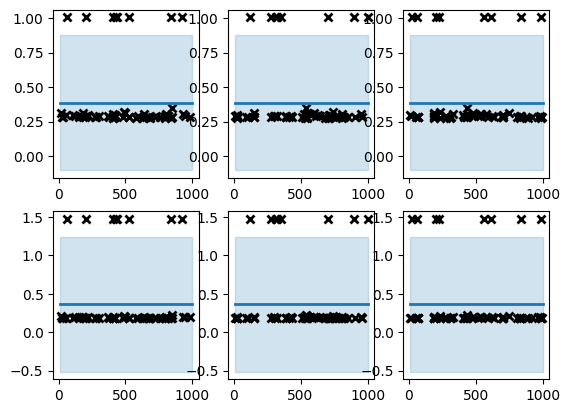

x_best =  [958.73172365 865.45142034 370.33059249]
acq_best =  [0.09726845 0.17475029]
C = [958.73172365 865.45142034 370.33059249]
Epoch 1/6
517/517 [==============================] - 11s 18ms/step - loss: 37647069184.0000 - mae: 201312.2656 - mse: 101657403392.0000 - val_loss: 21434181632.0000 - val_mae: 155765.2812 - val_mse: 57878073344.0000
Epoch 2/6
517/517 [==============================] - 9s 17ms/step - loss: 22350325760.0000 - mae: 163785.5312 - mse: 60351918080.0000 - val_loss: 20738199552.0000 - val_mae: 154121.4844 - val_mse: 55998734336.0000
Epoch 3/6
517/517 [==============================] - 6s 12ms/step - loss: 21814261760.0000 - mae: 161645.5469 - mse: 58904403968.0000 - val_loss: 20488542208.0000 - val_mae: 159475.6094 - val_mse: 55324594176.0000
Epoch 4/6
517/517 [==============================] - 8s 16ms/step - loss: 21592879104.0000 - mae: 160886.5156 - mse: 58306564096.0000 - val_loss: 20118777856.0000 - val_mae: 151057.4531 - val_mse: 54326124544.0000
Epoch 5/6


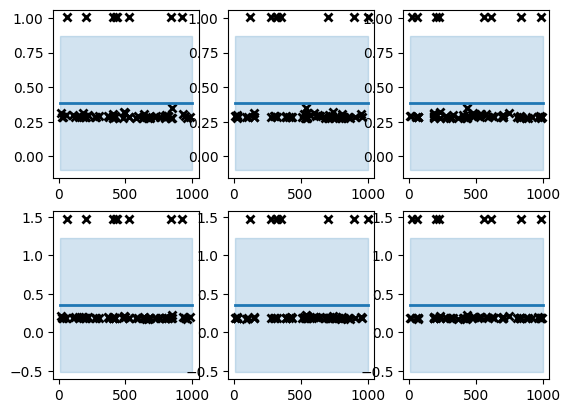

x_best =  [828.104481   899.79142911 471.40045565]
acq_best =  [0.09660004 0.17352817]
C = [828.104481   899.79142911 471.40045565]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 50128916480.0000 - mae: 204500.5156 - mse: 106340057088.0000 - val_loss: 28009625600.0000 - val_mae: 165762.2031 - val_mse: 59417526272.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 28760117248.0000 - mae: 162898.4844 - mse: 61009661952.0000 - val_loss: 25733429248.0000 - val_mae: 156636.0000 - val_mse: 54588989440.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 27370936320.0000 - mae: 159945.7188 - mse: 58062667776.0000 - val_loss: 27263160320.0000 - val_mae: 165966.9844 - val_mse: 57834041344.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 27237988352.0000 - mae: 160861.3281 - mse: 57780649984.0000 - val_loss: 25757806592.0000 - val_mae: 160485.6875 - val_mse: 54640676864.0000
Epoch 5/6
517/5

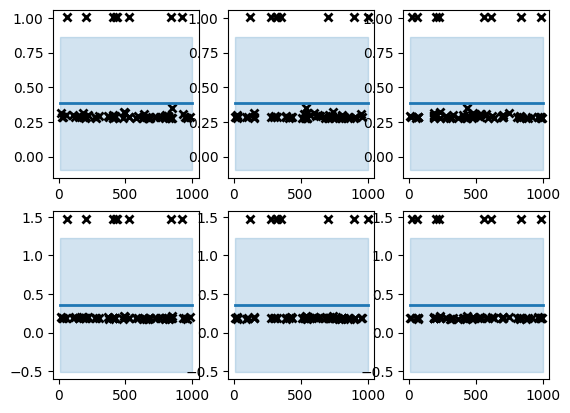

x_best =  [692.48565037 566.57544775 997.37191203]
acq_best =  [0.09594436 0.1723202 ]
C = [692.48565037 566.57544775 997.37191203]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 109760536576.0000 - mae: 207368.3281 - mse: 110049533952.0000 - val_loss: 60956016640.0000 - val_mae: 166580.3594 - val_mse: 61116452864.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 60897402880.0000 - mae: 163234.4219 - mse: 61057695744.0000 - val_loss: 57056460800.0000 - val_mae: 154973.9062 - val_mse: 57206657024.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 58732957696.0000 - mae: 161113.4375 - mse: 58887581696.0000 - val_loss: 54251233280.0000 - val_mae: 156864.1250 - val_mse: 54394028032.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57211592704.0000 - mae: 159130.7031 - mse: 57362173952.0000 - val_loss: 55219945472.0000 - val_mae: 151132.8594 - val_mse: 55365296128.0000
Epoch 5/6
517/

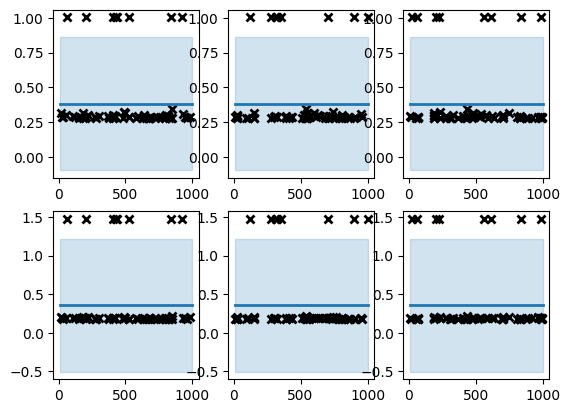

x_best =  [621.65433504  80.79827105 104.70653927]
acq_best =  [0.09528689 0.17113611]
C = [621.65433504  80.79827105 104.70653927]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 12962201600.0000 - mae: 222444.0469 - mse: 123793432576.0000 - val_loss: 8413020160.0000 - val_mae: 170514.8125 - val_mse: 80346906624.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 6926828032.0000 - mae: 166636.7188 - mse: 66153123840.0000 - val_loss: 6011556352.0000 - val_mae: 161284.7656 - val_mse: 57411850240.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 6255777280.0000 - mae: 162126.4531 - mse: 59744251904.0000 - val_loss: 5850097664.0000 - val_mae: 162286.4219 - val_mse: 55869812736.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 6092008448.0000 - mae: 160941.4375 - mse: 58180186112.0000 - val_loss: 5794088960.0000 - val_mae: 158789.3438 - val_mse: 55334961152.0000
Epoch 5/6
517/517 [===

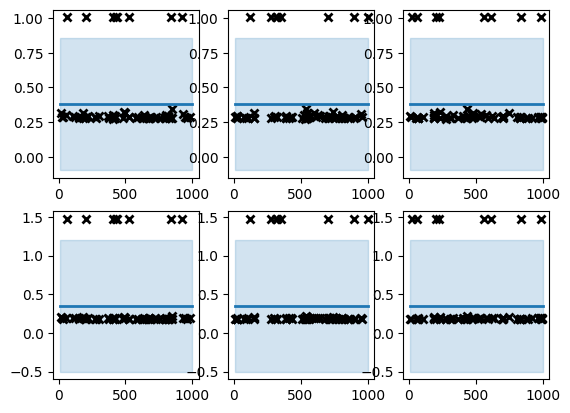

x_best =  [428.47309397 592.01422489  80.20662562]
acq_best =  [0.09463537 0.16997546]
C = [428.47309397 592.01422489  80.20662562]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 9229881344.0000 - mae: 214426.7031 - mse: 115073785856.0000 - val_loss: 5353976832.0000 - val_mae: 170463.5781 - val_mse: 66750189568.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 4961790976.0000 - mae: 163657.7812 - mse: 61860614144.0000 - val_loss: 4274125056.0000 - val_mae: 154285.4375 - val_mse: 53287026688.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 4682164224.0000 - mae: 160170.5000 - mse: 58374287360.0000 - val_loss: 4210652928.0000 - val_mae: 152363.9062 - val_mse: 52495683584.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 4588201472.0000 - mae: 158093.1094 - mse: 57202757632.0000 - val_loss: 4437421056.0000 - val_mae: 150376.3125 - val_mse: 55322988544.0000
Epoch 5/6
517/517 [====

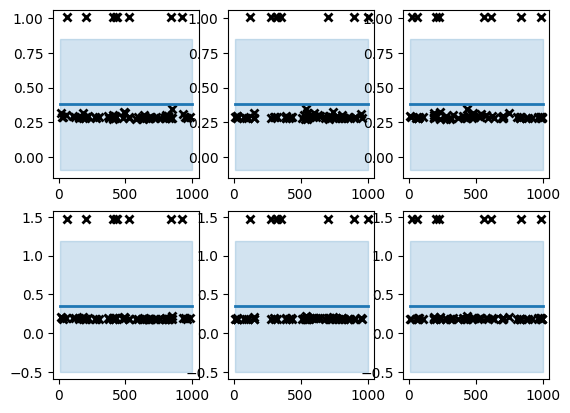

x_best =  [977.63192156 582.82842762 135.22665211]
acq_best =  [0.09400364 0.16879511]
C = [977.63192156 582.82842762 135.22665211]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 14662947840.0000 - mae: 208412.4375 - mse: 108430778368.0000 - val_loss: 8004768768.0000 - val_mae: 160339.6875 - val_mse: 59193995264.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 8170814976.0000 - mae: 163139.9219 - mse: 60421906432.0000 - val_loss: 7683940352.0000 - val_mae: 156243.2500 - val_mse: 56821526528.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 7922211328.0000 - mae: 160803.0625 - mse: 58583453696.0000 - val_loss: 7764379648.0000 - val_mae: 155554.0781 - val_mse: 57416380416.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 7778445824.0000 - mae: 158758.2344 - mse: 57520406528.0000 - val_loss: 7912960512.0000 - val_mae: 172784.5312 - val_mse: 58515001344.0000
Epoch 5/6
517/517 [===

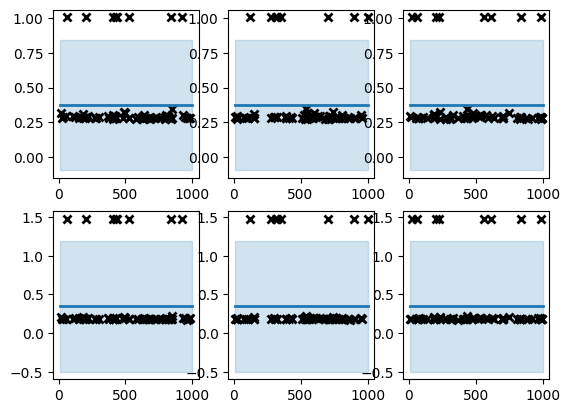

x_best =  [691.54622509 566.69990921 997.07112723]
acq_best =  [0.09339835 0.16768106]
C = [691.54622509 566.69990921 997.07112723]
Epoch 1/6
517/517 [==============================] - 4s 7ms/step - loss: 106820567040.0000 - mae: 207053.9844 - mse: 107134214144.0000 - val_loss: 59381633024.0000 - val_mae: 167124.2656 - val_mse: 59555909632.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 61121343488.0000 - mae: 163918.2031 - mse: 61300744192.0000 - val_loss: 54795915264.0000 - val_mae: 159357.7969 - val_mse: 54956695552.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 58227871744.0000 - mae: 159920.5625 - mse: 58398724096.0000 - val_loss: 53944983552.0000 - val_mae: 159439.1719 - val_mse: 54103277568.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 56617828352.0000 - mae: 157414.8438 - mse: 56783978496.0000 - val_loss: 54662516736.0000 - val_mae: 149735.7031 - val_mse: 54822940672.0000
Epoch 5/6
517/

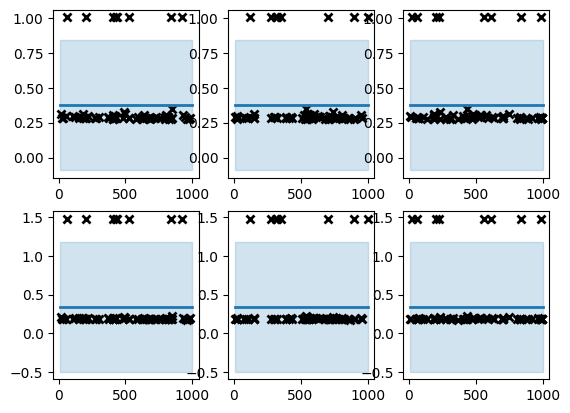

x_best =  [939.66738239 455.37735298 530.77391135]
acq_best =  [0.09279358 0.16658794]
C = [939.66738239 455.37735298 530.77391135]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 58096918528.0000 - mae: 209525.5625 - mse: 109456670720.0000 - val_loss: 35943059456.0000 - val_mae: 165008.0625 - val_mse: 67717926912.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 32486895616.0000 - mae: 163637.3750 - mse: 61206315008.0000 - val_loss: 31657744384.0000 - val_mae: 156530.0625 - val_mse: 59644186624.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 31235776512.0000 - mae: 161583.4688 - mse: 58849181696.0000 - val_loss: 29114165248.0000 - val_mae: 158711.7188 - val_mse: 54851973120.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 30894059520.0000 - mae: 159876.1406 - mse: 58205380608.0000 - val_loss: 28571222016.0000 - val_mae: 152770.7031 - val_mse: 53829087232.0000
Epoch 5/6
517/5

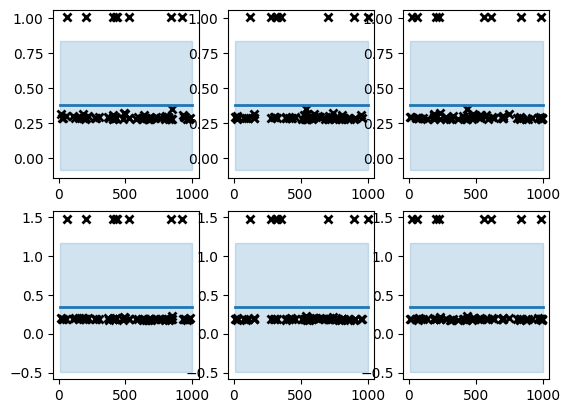

x_best =  [754.71941887  60.01975018 590.74847928]
acq_best =  [0.09218282 0.16551401]
C = [754.71941887  60.01975018 590.74847928]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 75397644288.0000 - mae: 225895.6875 - mse: 127630360576.0000 - val_loss: 50083364864.0000 - val_mae: 181067.3438 - val_mse: 84779188224.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 39502151680.0000 - mae: 166811.0625 - mse: 66867720192.0000 - val_loss: 33814450176.0000 - val_mae: 163164.1406 - val_mse: 57239732224.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 34989891584.0000 - mae: 160921.3281 - mse: 59229519872.0000 - val_loss: 33317345280.0000 - val_mae: 153243.1562 - val_mse: 56398254080.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 34061918208.0000 - mae: 158529.5781 - mse: 57658671104.0000 - val_loss: 32158883840.0000 - val_mae: 151724.5000 - val_mse: 54437265408.0000
Epoch 5/6
517/5

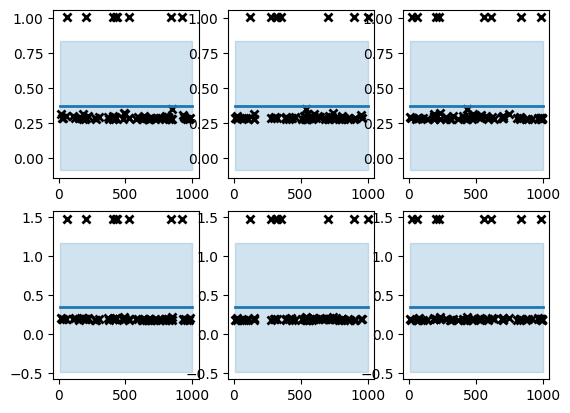

x_best =  [357.63657221 576.31757175 971.85881835]
acq_best =  [0.09160321 0.16446896]
C = [357.63657221 576.31757175 971.85881835]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 114426339328.0000 - mae: 217574.7500 - mse: 117739487232.0000 - val_loss: 63861927936.0000 - val_mae: 162924.2500 - val_mse: 65710940160.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 61841190912.0000 - mae: 165273.2031 - mse: 63631638528.0000 - val_loss: 54334455808.0000 - val_mae: 162362.5156 - val_mse: 55907581952.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 57983598592.0000 - mae: 162992.0000 - mse: 59662381056.0000 - val_loss: 54512222208.0000 - val_mae: 156138.5625 - val_mse: 56090517504.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 56427503616.0000 - mae: 159888.3281 - mse: 58061307904.0000 - val_loss: 52574339072.0000 - val_mae: 151644.7500 - val_mse: 54096527360.0000
Epoch 5/6
517/

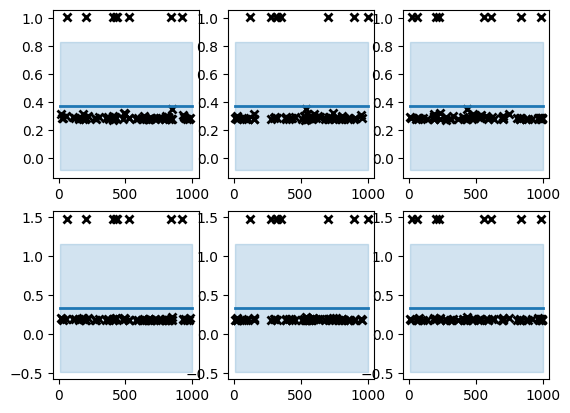

x_best =  [802.10310467 621.18521457 426.69294921]
acq_best =  [0.09102658 0.16343051]
C = [802.10310467 621.18521457 426.69294921]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 46147313664.0000 - mae: 208327.2656 - mse: 108150677504.0000 - val_loss: 25674696704.0000 - val_mae: 160441.8906 - val_mse: 60170973184.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 25920573440.0000 - mae: 163522.7812 - mse: 60747177984.0000 - val_loss: 22936225792.0000 - val_mae: 154268.7500 - val_mse: 53753085952.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 24911894528.0000 - mae: 160726.5781 - mse: 58383339520.0000 - val_loss: 23089926144.0000 - val_mae: 157612.1875 - val_mse: 54113300480.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 24282361856.0000 - mae: 158493.0312 - mse: 56907923456.0000 - val_loss: 22642327552.0000 - val_mae: 152958.7344 - val_mse: 53064327168.0000
Epoch 5/6
517/5

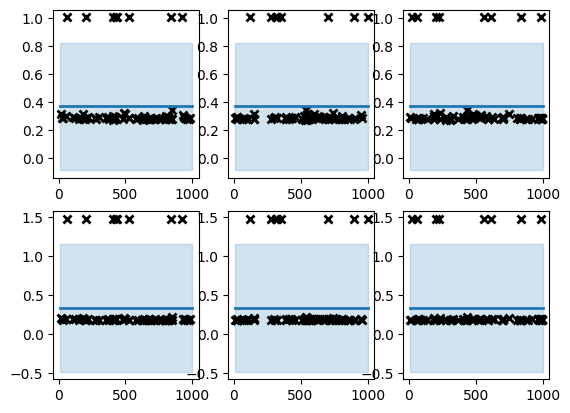

x_best =  [164.8878668  313.86563959 490.98956101]
acq_best =  [0.0904627 0.1624236]
C = [164.8878668  313.86563959 490.98956101]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 63124570112.0000 - mae: 229215.4219 - mse: 128565420032.0000 - val_loss: 46606991360.0000 - val_mae: 202692.3281 - val_mse: 94924210176.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 35045367808.0000 - mae: 170804.7969 - mse: 71376666624.0000 - val_loss: 28796618752.0000 - val_mae: 158614.9688 - val_mse: 58649841664.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 29631856640.0000 - mae: 162883.0625 - mse: 60350951424.0000 - val_loss: 27581478912.0000 - val_mae: 158537.5781 - val_mse: 56174956544.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 28937648128.0000 - mae: 160761.7031 - mse: 58937057280.0000 - val_loss: 27879464960.0000 - val_mae: 153896.0312 - val_mse: 56781885440.0000
Epoch 5/6
517/517

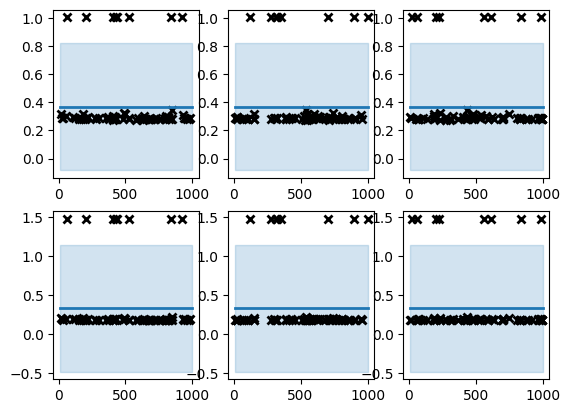

x_best =  [266.34094841 670.67258134 377.87133816]
acq_best =  [0.08991859 0.161431  ]
C = [266.34094841 670.67258134 377.87133816]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 43382415360.0000 - mae: 216353.4688 - mse: 114806734848.0000 - val_loss: 25221191680.0000 - val_mae: 160820.0938 - val_mse: 66745036800.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 23526766592.0000 - mae: 164338.8281 - mse: 62260953088.0000 - val_loss: 20764882944.0000 - val_mae: 154896.9688 - val_mse: 54951829504.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 22119426048.0000 - mae: 161049.3281 - mse: 58536497152.0000 - val_loss: 20945131520.0000 - val_mae: 153778.0625 - val_mse: 55428861952.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 21882122240.0000 - mae: 160510.1406 - mse: 57908551680.0000 - val_loss: 20602488832.0000 - val_mae: 154837.9844 - val_mse: 54522093568.0000
Epoch 5/6
517/5

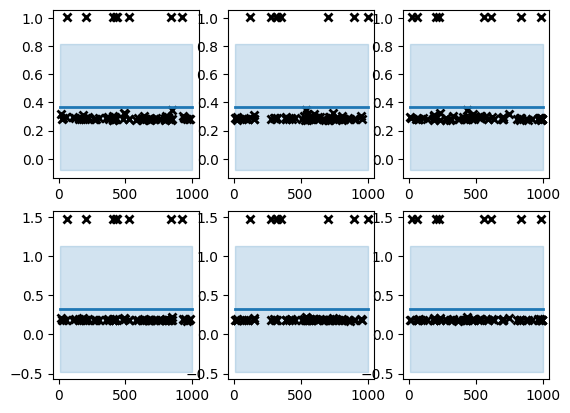

x_best =  [921.86518959 431.85796958 134.82895777]
acq_best =  [0.08937939 0.16045268]
C = [921.86518959 431.85796958 134.82895777]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 57038663680.0000 - mae: 538371.5000 - mse: 423040581632.0000 - val_loss: 57982795776.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 57038639104.0000 - mae: 538371.3750 - mse: 423040679936.0000 - val_loss: 57982795776.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 57038655488.0000 - mae: 538371.2500 - mse: 423040811008.0000 - val_loss: 57982795776.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 57038680064.0000 - mae: 538371.1875 - mse: 423040811008.0000 - val_loss: 57982795776.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

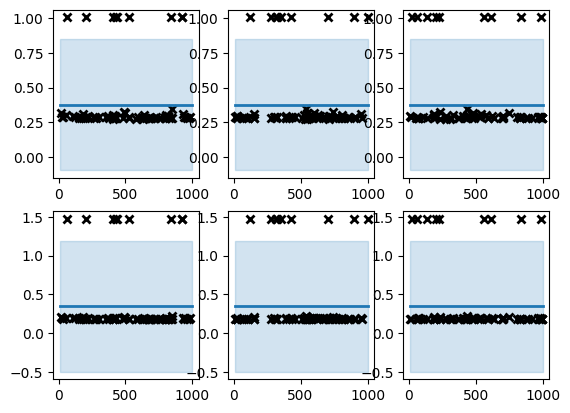

x_best =  [588.69865681 610.12431874 347.27273826]
acq_best =  [0.09357269 0.16799904]
C = [588.69865681 610.12431874 347.27273826]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 36802744320.0000 - mae: 205125.2031 - mse: 105975996416.0000 - val_loss: 20213772288.0000 - val_mae: 161616.1094 - val_mse: 58206732288.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 21675153408.0000 - mae: 164988.4062 - mse: 62414901248.0000 - val_loss: 20476678144.0000 - val_mae: 169385.8125 - val_mse: 58963771392.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 20192360448.0000 - mae: 160207.8281 - mse: 58145062912.0000 - val_loss: 18851684352.0000 - val_mae: 152468.9531 - val_mse: 54284505088.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 20590172160.0000 - mae: 162616.0938 - mse: 59290607616.0000 - val_loss: 22450751488.0000 - val_mae: 165551.1875 - val_mse: 64648298496.0000
Epoch 5/6
517/5

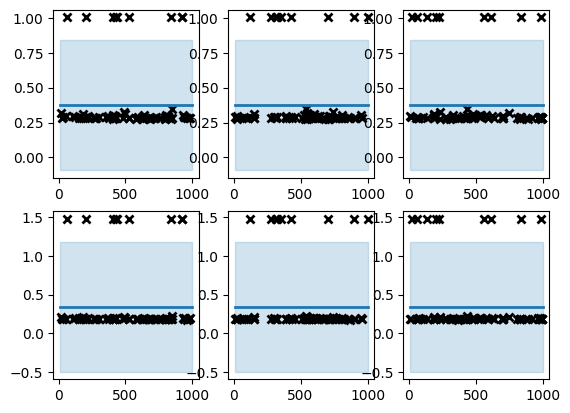

x_best =  [906.50347363 858.19318411 211.62712945]
acq_best =  [0.09303398 0.16702186]
C = [906.50347363 858.19318411 211.62712945]
Epoch 1/6
517/517 [==============================] - 8s 13ms/step - loss: 89527377920.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 91009302528.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 6s 12ms/step - loss: 89527418880.0000 - mae: 538371.3750 - mse: 423040712704.0000 - val_loss: 91009302528.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 89527435264.0000 - mae: 538371.6875 - mse: 423040745472.0000 - val_loss: 91009302528.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 8s 15ms/step - loss: 89527492608.0000 - mae: 538371.2500 - mse: 423040974848.0000 - val_loss: 91009302528.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoc

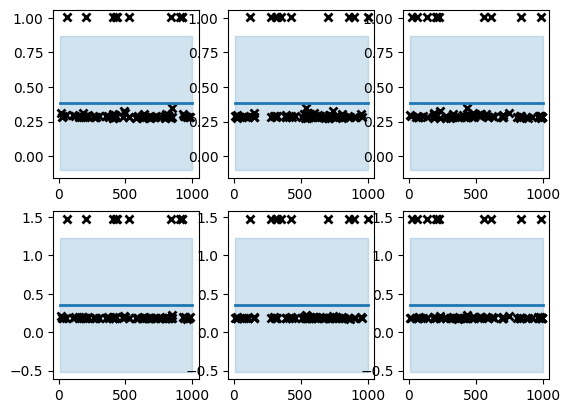

x_best =  [766.85604519  12.01136923 482.81609247]
acq_best =  [0.09683107 0.17385212]
C = [766.85604519  12.01136923 482.81609247]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 204251398144.0000 - mae: 538371.5000 - mse: 423040483328.0000 - val_loss: 207632220160.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 204251398144.0000 - mae: 538371.5000 - mse: 423040647168.0000 - val_loss: 207632220160.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 204251398144.0000 - mae: 538371.7500 - mse: 423040778240.0000 - val_loss: 207632220160.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 204251463680.0000 - mae: 538371.2500 - mse: 423040876544.0000 - val_loss: 207632220160.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


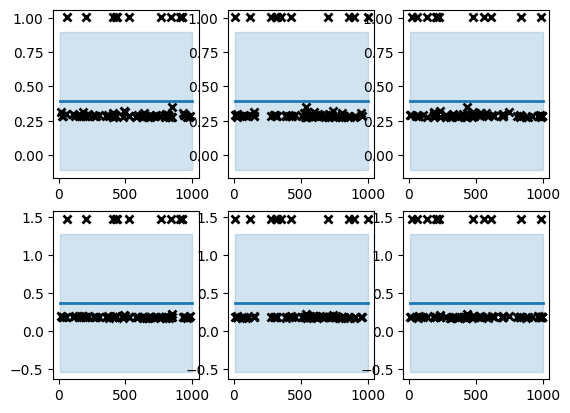

x_best =  [ 58.59183225  91.94457447 120.06899146]
acq_best =  [0.10029454 0.18008292]
C = [ 58.59183225  91.94457447 120.06899146]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 17809588224.0000 - mae: 247566.6719 - mse: 148325875712.0000 - val_loss: 14455326720.0000 - val_mae: 221392.2969 - val_mse: 120390017024.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 12541104128.0000 - mae: 203196.3125 - mse: 104447434752.0000 - val_loss: 9933792256.0000 - val_mae: 191423.5781 - val_mse: 82732449792.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 8459699200.0000 - mae: 168827.0312 - mse: 70455582720.0000 - val_loss: 7256868864.0000 - val_mae: 160613.9219 - val_mse: 60437815296.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 7504640512.0000 - mae: 163261.3750 - mse: 62501396480.0000 - val_loss: 6958182400.0000 - val_mae: 160465.0469 - val_mse: 57950203904.0000
Epoch 5/6
517/517 

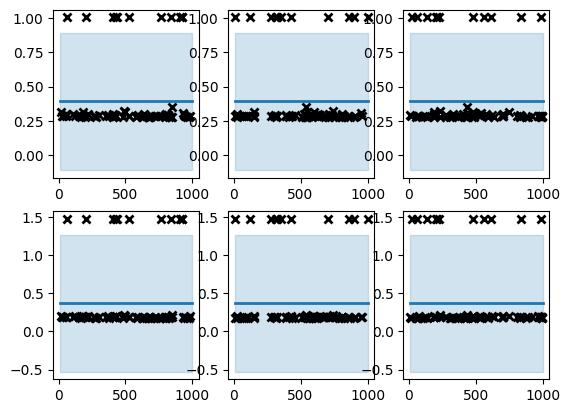

x_best =  [476.57140058 454.44309769 325.41989906]
acq_best =  [0.09974355 0.17907697]
C = [476.57140058 454.44309769 325.41989906]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 37038436352.0000 - mae: 213689.9688 - mse: 113816666112.0000 - val_loss: 22383321088.0000 - val_mae: 163632.5156 - val_mse: 68782374912.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 20219793408.0000 - mae: 163525.1250 - mse: 62133944320.0000 - val_loss: 19803351040.0000 - val_mae: 161374.8125 - val_mse: 60854276096.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 19052417024.0000 - mae: 160377.4844 - mse: 58546724864.0000 - val_loss: 22290505728.0000 - val_mae: 167148.9688 - val_mse: 68497162240.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 18555699200.0000 - mae: 158882.9219 - mse: 57020280832.0000 - val_loss: 19734347776.0000 - val_mae: 169104.7188 - val_mse: 60642197504.0000
Epoch 5/6
517/5

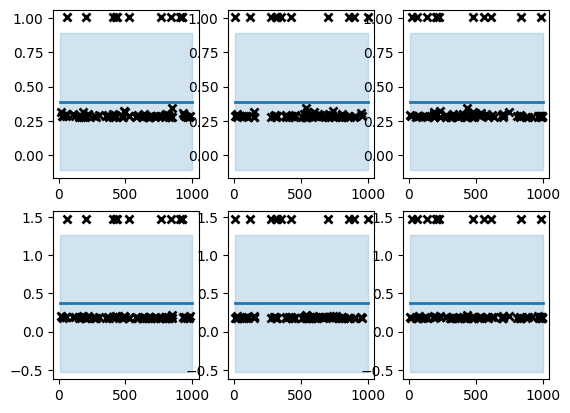

x_best =  [693.67339954 664.69725338 170.89446367]
acq_best =  [0.09922003 0.17811054]
C = [693.67339954 664.69725338 170.89446367]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 68663803904.0000 - mae: 516376.3750 - mse: 401787846656.0000 - val_loss: 21617203200.0000 - val_mae: 225276.8125 - val_mse: 126493171712.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 13414075392.0000 - mae: 180268.0469 - mse: 78492311552.0000 - val_loss: 10043210752.0000 - val_mae: 170053.1719 - val_mse: 58767507456.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 10118140928.0000 - mae: 161467.4531 - mse: 59206033408.0000 - val_loss: 9822856192.0000 - val_mae: 168620.2031 - val_mse: 57478070272.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 9810963456.0000 - mae: 159134.5625 - mse: 57408565248.0000 - val_loss: 9238844416.0000 - val_mae: 154515.1094 - val_mse: 54060793856.0000
Epoch 5/6
517/51

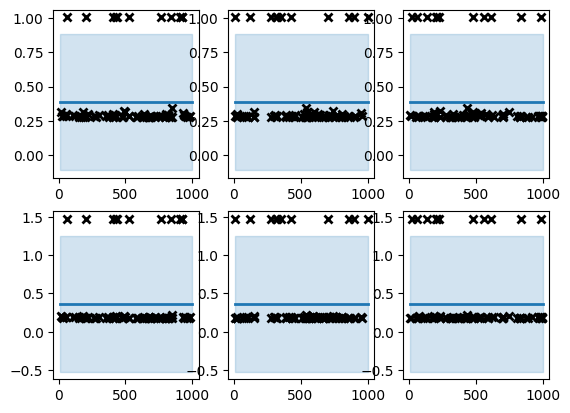

x_best =  [265.96734144 353.02973061 468.81224346]
acq_best =  [0.09871248 0.17715563]
C = [265.96734144 353.02973061 468.81224346]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 60586188800.0000 - mae: 227425.5469 - mse: 129232814080.0000 - val_loss: 40785838080.0000 - val_mae: 192917.8906 - val_mse: 86997811200.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 31369840640.0000 - mae: 169345.4062 - mse: 66913083392.0000 - val_loss: 26782990336.0000 - val_mae: 163328.9531 - val_mse: 57129115648.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 28169199616.0000 - mae: 163021.2500 - mse: 60085903360.0000 - val_loss: 25418094592.0000 - val_mae: 156971.6875 - val_mse: 54217740288.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 27204337664.0000 - mae: 159937.2812 - mse: 58027819008.0000 - val_loss: 25878351872.0000 - val_mae: 159698.6406 - val_mse: 55199473664.0000
Epoch 5/6
517/5

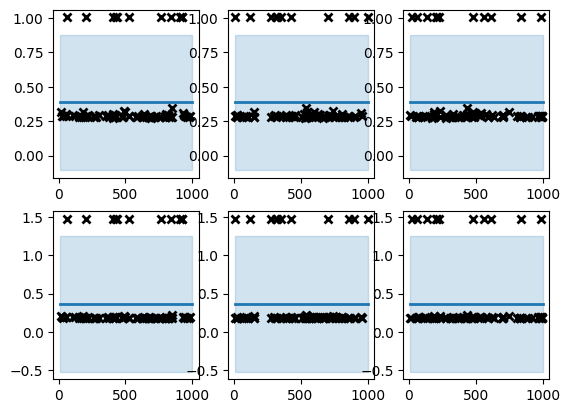

x_best =  [ 72.28465157 585.39273099 971.27496785]
acq_best =  [0.0981932  0.17621958]
C = [ 72.28465157 585.39273099 971.27496785]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 410889551872.0000 - mae: 538371.5000 - mse: 423040909312.0000 - val_loss: 417690583040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 410889158656.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 417690583040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 410889093120.0000 - mae: 538371.3125 - mse: 423040712704.0000 - val_loss: 417690583040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 410889256960.0000 - mae: 538371.7500 - mse: 423040811008.0000 - val_loss: 417690583040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


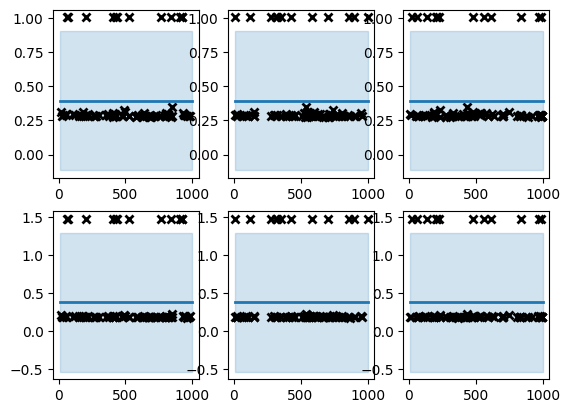

x_best =  [609.53194769 104.37289626 692.43016049]
acq_best =  [0.10135957 0.18191196]
C = [609.53194769 104.37289626 692.43016049]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 83865894912.0000 - mae: 220910.0000 - mse: 121117925376.0000 - val_loss: 53583351808.0000 - val_mae: 183380.9531 - val_mse: 77384228864.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 44506664960.0000 - mae: 165139.1719 - mse: 64275771392.0000 - val_loss: 39573676032.0000 - val_mae: 156383.9688 - val_mse: 57151639552.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 41327288320.0000 - mae: 162211.2969 - mse: 59684122624.0000 - val_loss: 38251982848.0000 - val_mae: 159369.5000 - val_mse: 55242846208.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 39915134976.0000 - mae: 160188.3438 - mse: 57644744704.0000 - val_loss: 38065217536.0000 - val_mae: 152903.6875 - val_mse: 54973145088.0000
Epoch 5/6
517/5

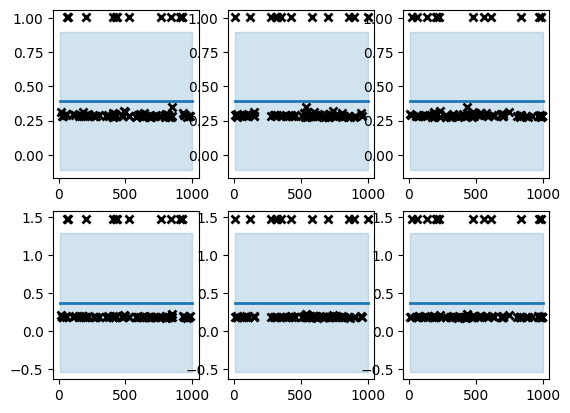

x_best =  [109.27341555 194.04361263  59.46434404]
acq_best =  [0.10082254 0.1809773 ]
C = [109.27341555 194.04361263  59.46434404]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 8143788032.0000 - mae: 236167.6094 - mse: 136948457472.0000 - val_loss: 6650646016.0000 - val_mae: 216425.1875 - val_mse: 111838937088.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 5211645952.0000 - mae: 185291.0625 - mse: 87640088576.0000 - val_loss: 3917042688.0000 - val_mae: 161306.5469 - val_mse: 65869402112.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 3779943168.0000 - mae: 164598.1719 - mse: 63563829248.0000 - val_loss: 3769209600.0000 - val_mae: 163508.8438 - val_mse: 63383281664.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 3603793920.0000 - mae: 162460.8750 - mse: 60601552896.0000 - val_loss: 3344438272.0000 - val_mae: 161744.9375 - val_mse: 56240017408.0000
Epoch 5/6
517/517 [===

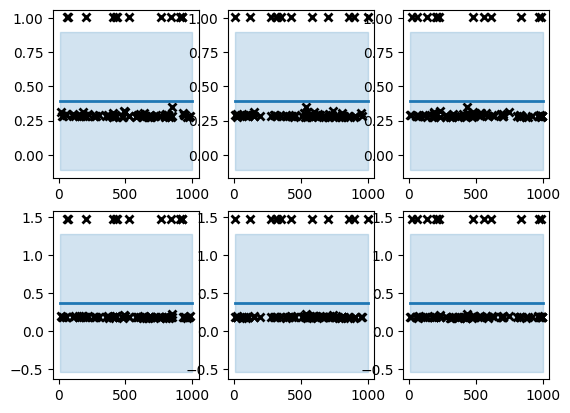

x_best =  [512.11060854 869.25464154 365.03453391]
acq_best =  [0.10032088 0.18005599]
C = [512.11060854 869.25464154 365.03453391]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 39449985024.0000 - mae: 207973.2031 - mse: 108071362560.0000 - val_loss: 22060593152.0000 - val_mae: 164481.3438 - val_mse: 60433821696.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 22685149184.0000 - mae: 165234.8594 - mse: 62144753664.0000 - val_loss: 20094744576.0000 - val_mae: 157374.4062 - val_mse: 55048462336.0000
Epoch 3/6
517/517 [==============================] - 5s 9ms/step - loss: 21683841024.0000 - mae: 161787.4844 - mse: 59401666560.0000 - val_loss: 19536072704.0000 - val_mae: 153266.9219 - val_mse: 53518020608.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 21083160576.0000 - mae: 159705.0156 - mse: 57756200960.0000 - val_loss: 20028086272.0000 - val_mae: 159853.7344 - val_mse: 54865842176.0000
Epoch 5/6
517

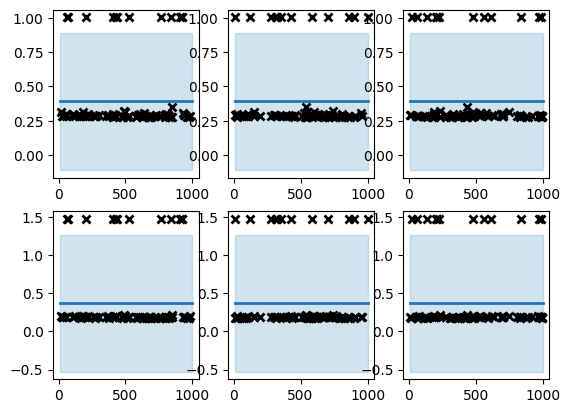

x_best =  [371.66734652  50.60943541 263.20573082]
acq_best =  [0.09983691 0.17916263]
C = [371.66734652  50.60943541 263.20573082]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 35715715072.0000 - mae: 233351.7500 - mse: 135694098432.0000 - val_loss: 28422813696.0000 - val_mae: 205404.2500 - val_mse: 107986305024.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 21316126720.0000 - mae: 178106.6719 - mse: 80985948160.0000 - val_loss: 17069630464.0000 - val_mae: 176624.2500 - val_mse: 64852156416.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 16660125696.0000 - mae: 165010.6250 - mse: 63296356352.0000 - val_loss: 15071309824.0000 - val_mae: 159209.7188 - val_mse: 57259978752.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 15926034432.0000 - mae: 162257.6406 - mse: 60507324416.0000 - val_loss: 16032510976.0000 - val_mae: 161720.2344 - val_mse: 60911849472.0000
Epoch 5/6
517/

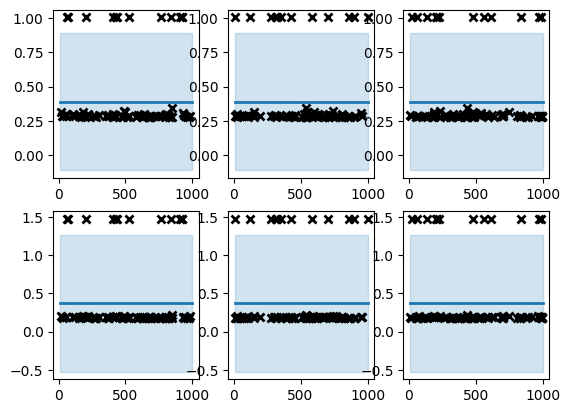

x_best =  [565.15113718 361.86772514 664.75877782]
acq_best =  [0.09934784 0.17827505]
C = [565.15113718 361.86772514 664.75877782]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 73430261760.0000 - mae: 211067.0625 - mse: 110461231104.0000 - val_loss: 41501417472.0000 - val_mae: 157679.1250 - val_mse: 62430531584.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 40570863616.0000 - mae: 162828.0469 - mse: 61030690816.0000 - val_loss: 41140584448.0000 - val_mae: 180579.7031 - val_mse: 61887705088.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 39011786752.0000 - mae: 161053.7812 - mse: 58685394944.0000 - val_loss: 35641896960.0000 - val_mae: 150906.4531 - val_mse: 53616050176.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 38134177792.0000 - mae: 158745.7188 - mse: 57365151744.0000 - val_loss: 35076370432.0000 - val_mae: 154461.0781 - val_mse: 52765327360.0000
Epoch 5/6
517/5

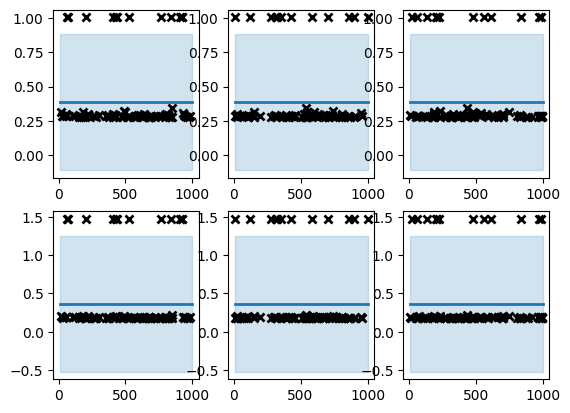

x_best =  [ 43.15971231 473.04247484 274.14991713]
acq_best =  [0.09887358 0.17738879]
C = [ 43.15971231 473.04247484 274.14991713]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 38989230080.0000 - mae: 241826.3281 - mse: 142217756672.0000 - val_loss: 33273767936.0000 - val_mae: 224197.8750 - val_mse: 121369878528.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 28824121344.0000 - mae: 204466.3594 - mse: 105139306496.0000 - val_loss: 21285158912.0000 - val_mae: 171754.6875 - val_mse: 77639974912.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 18304548864.0000 - mae: 165896.6094 - mse: 66767773696.0000 - val_loss: 16702897152.0000 - val_mae: 170013.5938 - val_mse: 60925517824.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 16582034432.0000 - mae: 161911.8594 - mse: 60484681728.0000 - val_loss: 15902073856.0000 - val_mae: 166907.1250 - val_mse: 58004434944.0000
Epoch 5/6
517

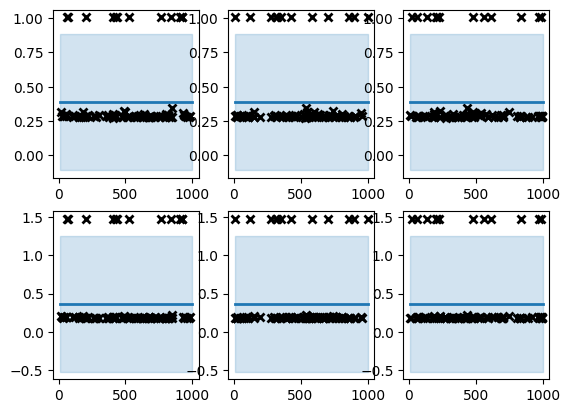

x_best =  [677.65403217 622.28355565 946.40140549]
acq_best =  [0.09838543 0.17650798]
C = [677.65403217 622.28355565 946.40140549]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 101617573888.0000 - mae: 205446.7656 - mse: 107372339200.0000 - val_loss: 61229576192.0000 - val_mae: 180082.0938 - val_mse: 64697094144.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 59474247680.0000 - mae: 165786.3281 - mse: 62842335232.0000 - val_loss: 52698734592.0000 - val_mae: 163371.5625 - val_mse: 55683121152.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 56095473664.0000 - mae: 162058.8438 - mse: 59272253440.0000 - val_loss: 57303326720.0000 - val_mae: 160534.1250 - val_mse: 60548493312.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 54297886720.0000 - mae: 158571.6562 - mse: 57372889088.0000 - val_loss: 50681745408.0000 - val_mae: 151750.8750 - val_mse: 53551915008.0000
Epoch 5/6
51

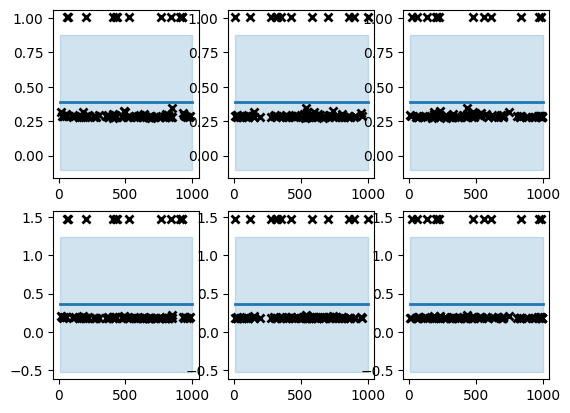

x_best =  [198.98466274 368.70163398  49.75714675]
acq_best =  [0.09792058 0.17566548]
C = [198.98466274 368.70163398  49.75714675]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 6427091968.0000 - mae: 230098.4844 - mse: 129164558336.0000 - val_loss: 5068898816.0000 - val_mae: 195301.9844 - val_mse: 101868888064.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 3609227008.0000 - mae: 172101.6250 - mse: 72533409792.0000 - val_loss: 2856141312.0000 - val_mae: 161241.6562 - val_mse: 57398386688.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 3020380928.0000 - mae: 162510.4844 - mse: 60699181056.0000 - val_loss: 2791790592.0000 - val_mae: 155898.9688 - val_mse: 56105205760.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 2927131648.0000 - mae: 161170.9688 - mse: 58825175040.0000 - val_loss: 2796556288.0000 - val_mae: 164179.5781 - val_mse: 56200814592.0000
Epoch 5/6
517/517 [===

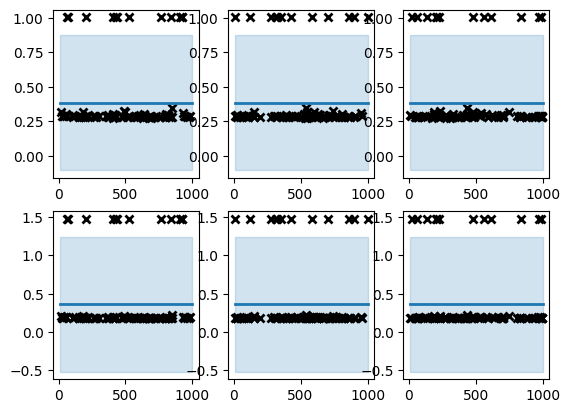

x_best =  [ 69.39587511 680.77802755  31.8025946 ]
acq_best =  [0.09746336 0.17482446]
C = [ 69.39587511 680.77802755  31.8025946 ]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 4255038720.0000 - mae: 233386.1719 - mse: 133788057600.0000 - val_loss: 3697978624.0000 - val_mae: 207729.3438 - val_mse: 116272553984.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 2679652096.0000 - mae: 184272.7500 - mse: 84253138944.0000 - val_loss: 1999688192.0000 - val_mae: 160424.4375 - val_mse: 62873075712.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 1920415616.0000 - mae: 162093.9688 - mse: 60380401664.0000 - val_loss: 1780838528.0000 - val_mae: 156958.9844 - val_mse: 55991726080.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 1844468608.0000 - mae: 160100.3281 - mse: 57992417280.0000 - val_loss: 1724820608.0000 - val_mae: 156603.7344 - val_mse: 54230298624.0000
Epoch 5/6
517/517 [===

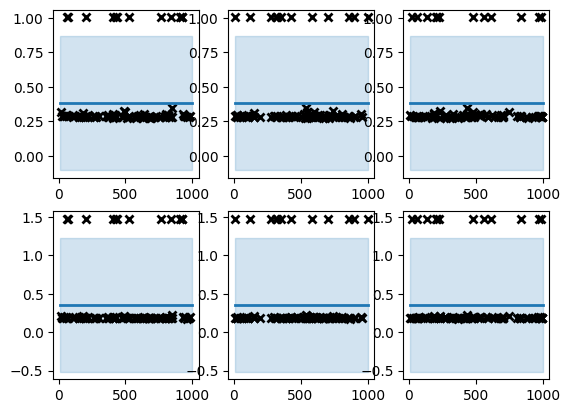

x_best =  [180.92050275 467.67797485 916.95030018]
acq_best =  [0.09699934 0.17399621]
C = [180.92050275 467.67797485 916.95030018]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 387907551232.0000 - mae: 538371.4375 - mse: 423040843776.0000 - val_loss: 394328506368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 387907813376.0000 - mae: 538371.5000 - mse: 423040942080.0000 - val_loss: 394328506368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 387907813376.0000 - mae: 538371.5625 - mse: 423040811008.0000 - val_loss: 394328506368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 387908009984.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 394328506368.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


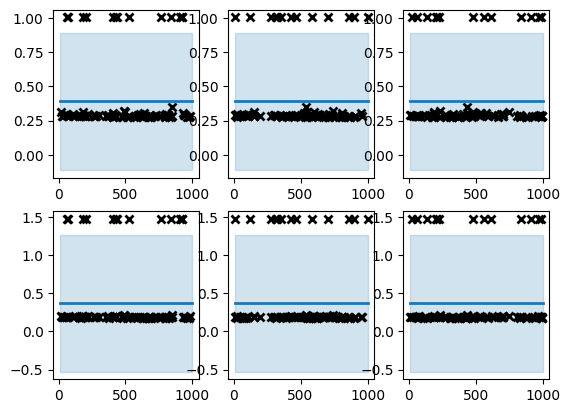

x_best =  [545.57255699  20.25335907 184.07713602]
acq_best =  [0.09990146 0.17921103]
C = [545.57255699  20.25335907 184.07713602]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 25161259008.0000 - mae: 235090.7500 - mse: 136687337472.0000 - val_loss: 19462066176.0000 - val_mae: 200743.1875 - val_mse: 105726689280.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 14939236352.0000 - mae: 178801.9062 - mse: 81156431872.0000 - val_loss: 11333791744.0000 - val_mae: 158112.5312 - val_mse: 61570035712.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 11430743040.0000 - mae: 162554.1094 - mse: 62096633856.0000 - val_loss: 10807097344.0000 - val_mae: 156182.3281 - val_mse: 58708766720.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 11051688960.0000 - mae: 161706.0312 - mse: 60037505024.0000 - val_loss: 10116578304.0000 - val_mae: 156980.3438 - val_mse: 54957518848.0000
Epoch 5/6
517/

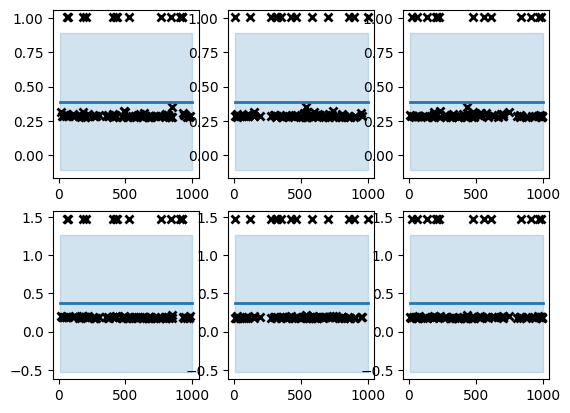

x_best =  [164.85168674 464.33984252 507.99552667]
acq_best =  [0.09945292 0.17839328]
C = [164.85168674 464.33984252 507.99552667]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 65164070912.0000 - mae: 227619.2188 - mse: 128276439040.0000 - val_loss: 50646085632.0000 - val_mae: 187607.6250 - val_mse: 99697532928.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 35513724928.0000 - mae: 170662.1562 - mse: 69909151744.0000 - val_loss: 28850182144.0000 - val_mae: 160216.8750 - val_mse: 56791887872.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 30781057024.0000 - mae: 162402.5000 - mse: 60592869376.0000 - val_loss: 28112644096.0000 - val_mae: 159200.8750 - val_mse: 55340027904.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 29745381376.0000 - mae: 160621.3750 - mse: 58554097664.0000 - val_loss: 27309078528.0000 - val_mae: 154549.5000 - val_mse: 53758214144.0000
Epoch 5/6
517/5

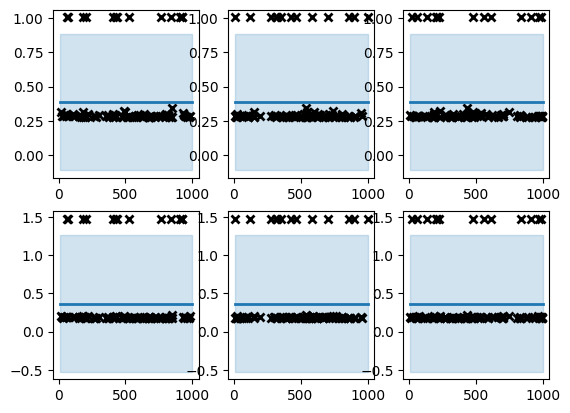

x_best =  [411.81731696 149.05091625 208.89341846]
acq_best =  [0.09900516 0.17757501]
C = [411.81731696 149.05091625 208.89341846]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 25707151360.0000 - mae: 223723.7344 - mse: 123062419456.0000 - val_loss: 17231360000.0000 - val_mae: 193243.9688 - val_mse: 82487861248.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 14026119168.0000 - mae: 166752.6719 - mse: 67144048640.0000 - val_loss: 11753142272.0000 - val_mae: 158223.1406 - val_mse: 56263061504.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 12339352576.0000 - mae: 161259.1406 - mse: 59069345792.0000 - val_loss: 11347490816.0000 - val_mae: 156569.1875 - val_mse: 54321164288.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 12106235904.0000 - mae: 159877.6406 - mse: 57953345536.0000 - val_loss: 11473247232.0000 - val_mae: 160239.2500 - val_mse: 54923161600.0000
Epoch 5/6
517/5

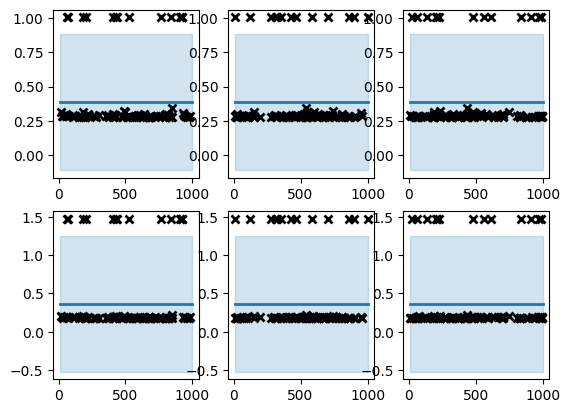

x_best =  [208.55660587 706.49584155 710.25642371]
acq_best =  [0.09856396 0.17676868]
C = [208.55660587 706.49584155 710.25642371]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 85946417152.0000 - mae: 219909.6250 - mse: 121007349760.0000 - val_loss: 54167494656.0000 - val_mae: 180727.4219 - val_mse: 76264439808.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 45743464448.0000 - mae: 166008.2969 - mse: 64403943424.0000 - val_loss: 39449661440.0000 - val_mae: 160260.2031 - val_mse: 55542616064.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 42142429184.0000 - mae: 162062.1406 - mse: 59333861376.0000 - val_loss: 41293873152.0000 - val_mae: 153768.6094 - val_mse: 58139172864.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 40856571904.0000 - mae: 159252.1406 - mse: 57523441664.0000 - val_loss: 40116162560.0000 - val_mae: 158105.9219 - val_mse: 56481034240.0000
Epoch 5/6
517/5

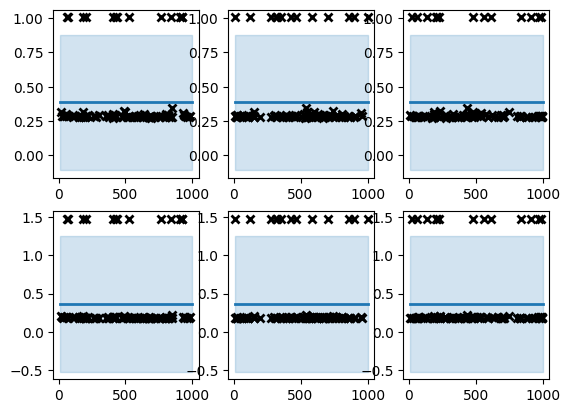

x_best =  [626.47414969  65.24743447 304.53851969]
acq_best =  [0.0981196 0.1759779]
C = [626.47414969  65.24743447 304.53851969]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 128832675840.0000 - mae: 538371.3750 - mse: 423040843776.0000 - val_loss: 130965200896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 128832708608.0000 - mae: 538371.3125 - mse: 423040876544.0000 - val_loss: 130965200896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 128832724992.0000 - mae: 538371.3750 - mse: 423040974848.0000 - val_loss: 130965200896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 128832724992.0000 - mae: 538371.3125 - mse: 423040450560.0000 - val_loss: 130965200896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Ep

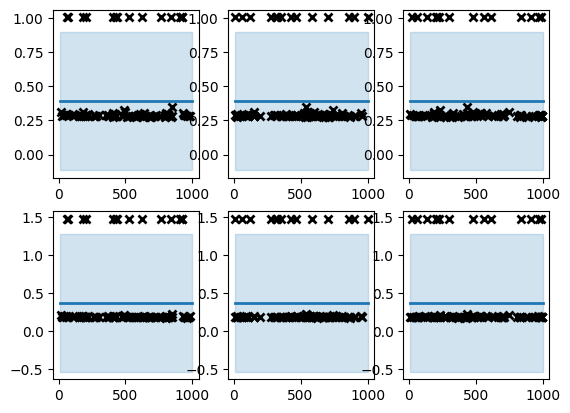

x_best =  [970.52868543 562.78355787 347.86135666]
acq_best =  [0.10080925 0.18080868]
C = [970.52868543 562.78355787 347.86135666]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 35530076160.0000 - mae: 203304.2500 - mse: 102138118144.0000 - val_loss: 21305346048.0000 - val_mae: 157648.6406 - val_mse: 61246226432.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 21259395072.0000 - mae: 163297.7500 - mse: 61114060800.0000 - val_loss: 22102945792.0000 - val_mae: 169087.1875 - val_mse: 63539032064.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 20666974208.0000 - mae: 161466.4531 - mse: 59411005440.0000 - val_loss: 18763880448.0000 - val_mae: 157441.7656 - val_mse: 53940232192.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 20121907200.0000 - mae: 159381.2656 - mse: 57844117504.0000 - val_loss: 19920429056.0000 - val_mae: 152229.5781 - val_mse: 57265020928.0000
Epoch 5/6
517/5

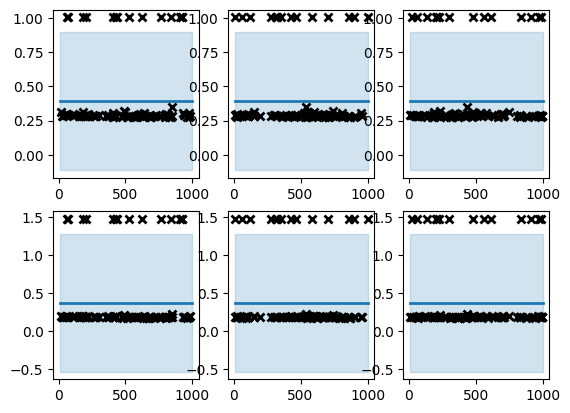

x_best =  [ 35.99866251 327.6138896  874.74976543]
acq_best =  [0.10033908 0.18001486]
C = [ 35.99866251 327.6138896  874.74976543]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 230749405184.0000 - mae: 371499.0625 - mse: 263788560384.0000 - val_loss: 106783727616.0000 - val_mae: 223592.3750 - val_mse: 122073194496.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 92864036864.0000 - mae: 206628.4375 - mse: 106160455680.0000 - val_loss: 73589735424.0000 - val_mae: 192243.4688 - val_mse: 84126408704.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 59830431744.0000 - mae: 167229.0781 - mse: 68396990464.0000 - val_loss: 51883073536.0000 - val_mae: 156574.4062 - val_mse: 59311718400.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 51842793472.0000 - mae: 160302.9062 - mse: 59265720320.0000 - val_loss: 48747954176.0000 - val_mae: 160505.5781 - val_mse: 55727706112.0000
Epoch 5/6
5

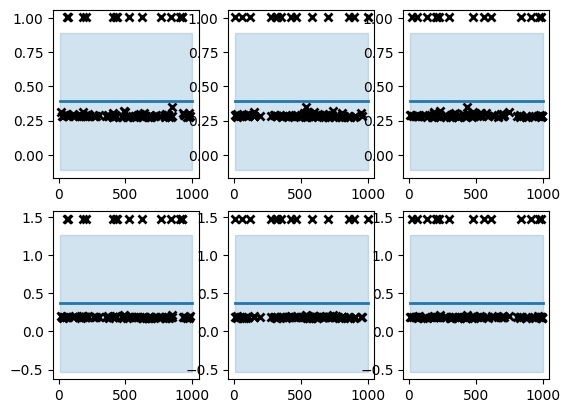

x_best =  [867.52521159 464.28527614 860.6060673 ]
acq_best =  [0.09990915 0.1792471 ]
C = [867.52521159 464.28527614 860.6060673 ]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 364072108032.0000 - mae: 538371.4375 - mse: 423040516096.0000 - val_loss: 370098176000.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 364071845888.0000 - mae: 538371.4375 - mse: 423040843776.0000 - val_loss: 370098176000.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 364071845888.0000 - mae: 538371.1875 - mse: 423040811008.0000 - val_loss: 370098176000.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 364071944192.0000 - mae: 538371.2500 - mse: 423040876544.0000 - val_loss: 370098176000.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


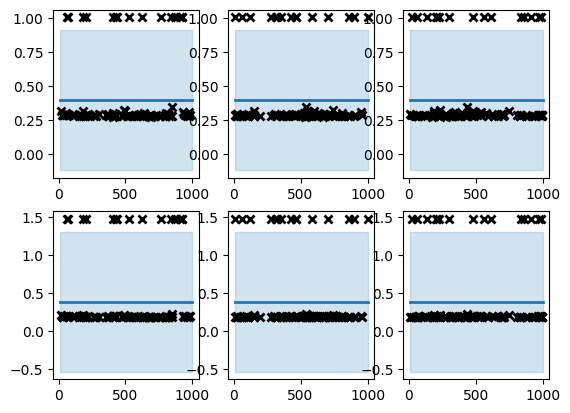

In [5]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)    
    
GP.updateGP()
GP.optimizeKernel()

if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mesmo_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)
    print("x_best = ", x_best)
    print("acq_best = ", acq_best)
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you do not have your metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [6]:
GP.Y

array([[0.29419369, 0.18598443],
       [0.28564915, 0.18932232],
       [0.29759279, 0.19859266],
       [1.00477791, 1.47428894],
       [0.30262184, 0.1890818 ],
       [0.2784611 , 0.18916298],
       [0.29140073, 0.18626657],
       [0.28049228, 0.18296638],
       [0.2835944 , 0.18939279],
       [0.29009011, 0.18382636],
       [0.28686163, 0.18429847],
       [1.00477791, 1.47428894],
       [0.28661677, 0.18368535],
       [0.31474146, 0.19612682],
       [0.31379372, 0.20421168],
       [1.00477791, 1.47428894],
       [1.00477791, 1.47428894],
       [0.30694675, 0.19387768],
       [0.28175259, 0.1872731 ],
       [0.29017848, 0.18408881],
       [1.00477791, 1.47428894],
       [0.27889758, 0.19352134],
       [0.28235841, 0.18549262],
       [0.27855667, 0.18144432],
       [0.3472217 , 0.22126141],
       [1.00477791, 1.47428894],
       [0.27800566, 0.18509744],
       [0.28250194, 0.17993441],
       [0.28118706, 0.18745683],
       [0.28076053, 0.18787129],
       [0.

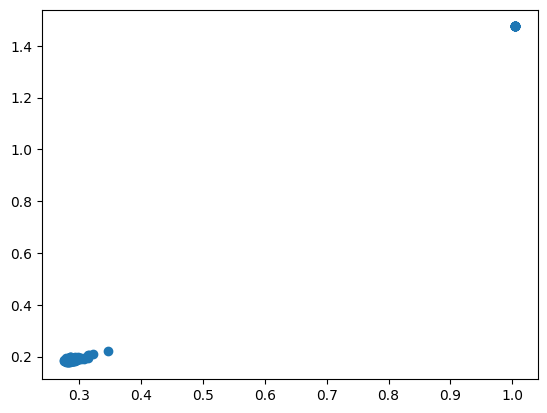

In [7]:
plt.scatter(GP.Y[:,0],GP.Y[:,1])

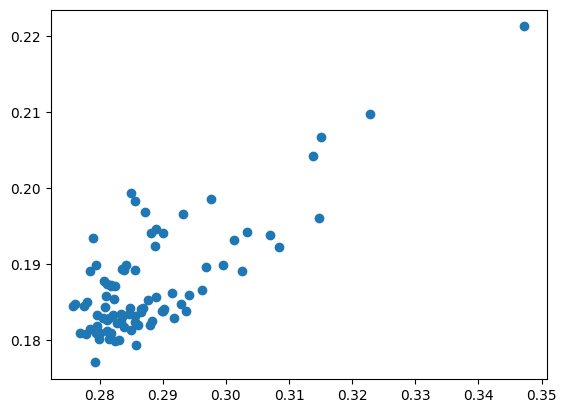

In [12]:
results = np.array([x for x in GP.Y if x[0]< 0.9])

plt.scatter(results[:,0],results[:,1])

In [13]:
results

array([[0.29419369, 0.18598443],
       [0.28564915, 0.18932232],
       [0.29759279, 0.19859266],
       [0.30262184, 0.1890818 ],
       [0.2784611 , 0.18916298],
       [0.29140073, 0.18626657],
       [0.28049228, 0.18296638],
       [0.2835944 , 0.18939279],
       [0.29009011, 0.18382636],
       [0.28686163, 0.18429847],
       [0.28661677, 0.18368535],
       [0.31474146, 0.19612682],
       [0.31379372, 0.20421168],
       [0.30694675, 0.19387768],
       [0.28175259, 0.1872731 ],
       [0.29017848, 0.18408881],
       [0.27889758, 0.19352134],
       [0.28235841, 0.18549262],
       [0.27855667, 0.18144432],
       [0.3472217 , 0.22126141],
       [0.27800566, 0.18509744],
       [0.28250194, 0.17993441],
       [0.28118706, 0.18745683],
       [0.28076053, 0.18787129],
       [0.28091803, 0.18435587],
       [0.28566515, 0.19834559],
       [0.30327588, 0.1943035 ],
       [0.28477588, 0.18425365],
       [0.28337422, 0.18235856],
       [0.2899071 , 0.18383124],
       [0.

In [10]:
results = []
for c in np.linspace(0,0.1,100):
    results.append([c, MOOnnHousesRegression(c)])
    


NameError: name 'MOOnnHousesRegression' is not defined

In [ ]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in GP.Y if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

In [ ]:
plt.scatter(evs, mae)

In [ ]:
mae

In [ ]:
results

In [ ]:
MOOnnHousesRegression(0)